## Прогнозирование стоимости автомобиля по характеристикам

In [101]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import sys
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import ExtraTreeRegressor
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder,RobustScaler
from sklearn.model_selection import GridSearchCV

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sns.set()

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Setup

In [7]:
VERSION    = 19
DIR_TRAIN  = '../input/autoru-parsed170321-converted/' # auto.ru от 17.03.21, отформатированная под тестовые данные
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.2
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

# Data

In [8]:
!ls ../input/

autoru-parsed170321-converted  sf-dst-car-price-prediction


In [9]:
train = pd.read_csv(DIR_TRAIN+'cars_data.csv') # мой подготовленный датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# Func

In [10]:
### Функция считает описательные статистики для числовых признаков датасета, возвращает датафрейм
def get_stats(dataset):
    col_types = dataset.dtypes.reset_index()
    col_types.columns=['Name', 'type']
    num_cols = list(col_types[col_types['type'] !='object']['Name'])
    stats = pd.DataFrame(columns=['feature_name', 'min', 'max', 'median', 'q1', 'q3', 'iqr', 'l_border', 'r_border'])
    
    for i in range(len(num_cols)):
        q1 = dataset[num_cols[i]].quantile(0.25)
        q2 = dataset[num_cols[i]].median()
        q3 = dataset[num_cols[i]].quantile(0.75)
        iqr = q3 - q1
        left_outliers_border = q1 - 1.5 * iqr
        right_outliers_border = q3 + 1.5 * iqr
        minimum = dataset[num_cols[i]].min()
        maximum = dataset[num_cols[i]].max()
        stats.loc[i] = [num_cols[i], minimum, maximum, q2, q1, q3, iqr, left_outliers_border, right_outliers_border]
    
    return stats

In [11]:
### Функция исправляющая столбец со сроком владения
def ownership_fix(record):
    if record == None:
        return(None)
    digits = re.findall(r'\d+', record)
    letters = re.findall(r'\D+', record)
    if len(digits) == 2:
        return (int(digits[0])*12 + int(digits[1]))
    elif len(digits) == 1:
        if 'го' in letters[0] or 'ле' in letters[0]:
            return(int(digits[0])*12)
        if 'ме' in letters[0]:
            return(int(digits[0]))

In [12]:
### Функция поиска опции в списке возможных опций для заполнения dummy-переменных
def find_equip (car, equip):
    if equip in car:
        return 1
    return 0

In [13]:
### Функция для обработки столбца с текстовыми словарями опций автомобиля

# Список уникальных опций
test_options = ['12-inch-wheels',
                '12v-socket',
                '13-inch-wheels',
                '14-inch-wheels',
                '15-inch-wheels',
                '16-inch-wheels',
                '17-inch-wheels',
                '18-inch-wheels',
                '19-inch-wheels',
                '20-inch-wheels',
                '21-inch-wheels',
                '22-inch-wheels',
                '220v-socket',
                '23-inch-wheels',
                '24-inch-wheels',
                '25-inch-wheels',
                '27-inch-wheels',
                '360-camera',
                'abs',
                'activ-suspension',
                'adaptive-light',
                'adj-pedals',
                'advanced-frontlighting-system',
                'air-suspension',
                'airbag-2',
                'airbag-4',
                'airbag-6',
                'airbag-curtain',
                'airbag-driver',
                'airbag-passenger',
                'airbag-rear-side',
                'airbag-side',
                'airbrush',
                'alarm',
                'alcantara',
                'alloy-wheel-disks',
                'android-auto',
                'apple-carplay',
                'armored',
                'ashtray-and-cigarette-lighter',
                'asr',
                'audiopreparation',
                'audiosystem',
                'audiosystem-cd',
                'audiosystem-tv',
                'auto-cruise',
                'auto-mirrors',
                'auto-park',
                'automatic-lighting-control',
                'aux',
                'bas',
                'black-roof',
                'blind-spot',
                'bluetooth',
                'body-kit',
                'body-mouldings',
                'climate-control',
                'climate-control-1',
                'climate-control-2',
                'climate-control-3',
                'collision-prevention-assist',
                'combo-interior',
                'computer',
                'condition',
                'cooling-box',
                'cruise-control',
                'dark-interior',
                'decorative-interior-lighting',
                'door-sill-panel',
                'drive-mode-sys',
                'driver-seat-electric',
                'driver-seat-manual',
                'driver-seat-memory',
                'driver-seat-support',
                'driver-seat-updown',
                'drl'
                'drowsy-driver-alert-system',
                'e-adjustment-wheel',
                'easy-trunk-opening',
                'eco-leather',
                'electro-mirrors',
                'electro-rear-seat',
                'electro-seat',
                'electro-trunk',
                'electro-window-all',
                'electro-window-back',
                'electro-window-front',
                'electronic-gage-panel',
                'engine-proof',
                'entertainment-system-for-rear-seat-passengers',
                'esp',
                'fabric-seats',
                'feedback-alarm',
                'folding-front-passenger-seat',
                'folding-tables-rear',
                'front-camera',
                'front-centre-armrest',
                'front-seat-support',
                'front-seats-heat',
                'front-seats-heat-vent',
                'gbo',
                'glonass',
                'halogen',
                'hatch',
                'hcc',
                'heated-wash-system',
                'high-beam-assist',
                'immo',
                'immobiliser-not-standard',
                'isofix',
                'isofix-front',
                'keyless-entry',
                'knee-airbag',
                'laminated-safety-glass',
                'lane-keeping-assist',
                'laser-lights',
                'leather',
                'leather-gear-stick',
                'led-lights',
                'light-cleaner',
                'light-interior',
                'light-sensor',
                'lock',
                'massage-seats',
                'mirrors-heat',
                'multi-wheel',
                'multizone-climate-control',
                'music-super',
                'navigation',
                'night-vision',
                'paint-metallic',
                'panorama-roof',
                'park-assist-f',
                'park-assist-r',
                'parktronik',
                'passenger-seat-electric',
                'passenger-seat-manual',
                'passenger-seat-memory',
                'passenger-seat-updown',
                'power-child-locks-rear-doors',
                'power-latching-doors',
                'programmed-block-heater',
                'projection-display',
                'ptf'
                'rain-sensor',
                'rear-camera',
                'rear-seat-heat-vent',
                'rear-seats-heat',
                'reduce-spare-wheel',
                'remote-engine-start',
                'roller-blind-for-rear-window',
                'roller-blinds-for-rear-side-windows',
                'roof-rails',
                'seat-memory',
                'seat-transformation',
                'seats-2',
                'seats-4',
                'seats-5',
                'seats-6',
                'seats-7',
                'seats-8',
                'seats-9',
                'seats-heat',
                'servo',
                'spare-wheel',
                'sport-pedals',
                'sport-seats',
                'sport-suspension',
                'start-button',
                'start-stop-function',
                'steel-wheels',
                'steering-wheel-gear-shift-paddles',
                'third-rear-headrest',
                'third-row-seats',
                'tinted-glass',
                'traffic-sign-recognition',
                'turnbuckle',
                'tyre-pressure',
                'usb',
                'velvet-seats',
                'voice-recognition',
                'volume-sensor',
                'vsm',
                'wheel-configuration1',
                'wheel-configuration2',
                'wheel-configuration3',
                'wheel-heat',
                'wheel-leather',
                'wheel-memory',
                'wheel-power',
                'windcleaner-heat',
                'windscreen-heat',
                'wireless-charger',
                'xenon',
                'ya-auto']

def test_options_fix(record):
    options = []
    if type(record)==str:
        options_dict = json.loads(record)
        for key in options_dict:
            if key in test_options:
                options.append(key)
    return(options)

In [14]:
### Функция для разбивки текстового списка на элементы
def clear_text_list (text_list):
    clear_list = [element.strip("'[]") for element in text_list.split("', '")]
    return clear_list

In [15]:
### Функция для получения новых признаков из пробега автомобилей, сгруппированных по двум признакам

def mileage_features(group1, group2, dataset):
    
    temp = train.pivot_table(values=['mileage'], index=[group1, group2], aggfunc=[np.min, np.max, np.mean, np.median, np.std]).reset_index()
    temp.columns = [
                    group1,
                    group2,
                    'min_mileage by ' + group1 + ' ' + group2,
                    'max_mileage by ' + group1 + ' ' + group2,
                    'mean_mileage by ' + group1 + ' ' + group2,
                    'median_mileage by ' + group1 + ' ' + group2,
                    'std_mileage by ' + group1 + ' ' + group2,
    ]
    temp.fillna(0, inplace=True)
    dataset = dataset.merge(temp, on=[group1, group2], how='left')
    
    return dataset

In [16]:
def preproc_test(df_input):
    '''Подготовка тестового датасета'''
    df_output = df_input.copy()
    
    # убираем ненужные признаки
    test_to_drop = ['complectation_dict', 'image', 'model_info',
                'parsing_unixtime', 'sell_id', 'super_gen', 'vehicleConfiguration', 'priceCurrency']
    
    df_output.drop(test_to_drop, inplace=True, axis=1)
    
    # ################### fix ##############################################################
    # Исправляем объем двигателя
    df_output.engineDisplacement=pd.to_numeric(df_output.engineDisplacement.str.strip(' LTR'))
    
    # У электрических двигателей ставим объем 0
    df_output.engineDisplacement.fillna(0, inplace=True)
    
    # Исправляем мощность двигателя 
    df_output.enginePower = pd.to_numeric(df_output.enginePower.str.replace(u' N12', u''))
    
    # Исправляем столбец с количеством владельцев 
    df_output.Владельцы = df_output.Владельцы.apply(lambda x: x.strip(re.findall('\D+', x)[0]))
    df_output.Владельцы = df_output.Владельцы.astype(int)
    
    # Переводим столбец Владение в месяцы
    df_output.Владение.fillna('', inplace=True)
    df_output.Владение = df_output.Владение.apply(ownership_fix)
    
    # Заполним единственный Nan в ПТС 
    df_output.ПТС.fillna('Дубликат', inplace=True)
    
    # Обработаем столбец с опциями
    df_output.equipment_dict = df_output.equipment_dict.apply(test_options_fix)
    
    
    
    return df_output

# EDA

Сравним датасеты test и train 

train был получен путем парсинга auto.ru по состоянию на 17.03.21,и дальнейшей обработкой с целью приведения данных к виду, аналогичному test. Для экономии времени и ресурсов парсились только те марки автомобилей, которые присутствуют в test

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39136 entries, 0 to 39135
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             39136 non-null  object 
 1   brand                39136 non-null  object 
 2   car_url              39136 non-null  object 
 3   color                39136 non-null  object 
 4   description          38269 non-null  object 
 5   engineDisplacement   39136 non-null  float64
 6   enginePower          39136 non-null  int64  
 7   equipment_dict       39136 non-null  object 
 8   fuelType             39136 non-null  object 
 9   mileage              39136 non-null  float64
 10  modelDate            39136 non-null  int64  
 11  model_name           39136 non-null  object 
 12  name                 39136 non-null  object 
 13  numberOfDoors        39136 non-null  int64  
 14  productionDate       39136 non-null  int64  
 15  vehicleTransmission  39136 non-null 

Пропуски присутствуют только в столбце со сроком владения автомобилем и у некоторых автомобилей отсутствует текстовое описание.

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

В test картина аналогичная, много пропусков в столбце со сроком владения, слишком много пропусков в complectation_dict и приблизительно треть записей отсутствует для equipment_dict

Проведем первичную обработку test

In [19]:
test = preproc_test(test)

Посчитаем описательные статистики для train и test

In [20]:
train_stats = get_stats(train)
train_stats

,feature_name,min,max,median,q1,q3,iqr,l_border,r_border
0,engineDisplacement,0.0,6.6,2.0,1.6,3.0,1.4,-0.5,5.1
1,enginePower,41.0,639.0,170.0,131.0,238.0,107.0,-29.5,398.5
2,mileage,1.0,1000000.0,129000.0,75000.0,195000.0,120000.0,-105000.0,375000.0
3,modelDate,1937.0,2020.0,2011.0,2006.0,2014.0,8.0,1994.0,2026.0
4,numberOfDoors,2.0,5.0,5.0,4.0,5.0,1.0,2.5,6.5
5,productionDate,1948.0,2021.0,2012.0,2007.0,2016.0,9.0,1993.5,2029.5
6,Владельцы,1.0,3.0,2.0,1.0,3.0,2.0,-2.0,6.0
7,Владение,1.0,519.0,36.0,17.0,69.0,52.0,-61.0,147.0
8,Price,20000.0,57000000.0,1017500.0,569000.0,1856000.0,1287000.0,-1361500.0,3786500.0


In [21]:
test_stats = get_stats(test)
test_stats

,feature_name,min,max,median,q1,q3,iqr,l_border,r_border
0,engineDisplacement,0.0,6.6,2.0,1.8,3.0,1.2,2.220446e-16,4.80
1,enginePower,30.0,639.0,169.0,125.0,233.0,108.0,-3.700000e+01,395.00
2,mileage,1.0,1000000.0,149779.5,91153.5,215000.0,123846.5,-9.461625e+04,400769.75
3,modelDate,1904.0,2020.0,2008.0,2004.0,2012.0,8.0,1.992000e+03,2024.00
4,numberOfDoors,0.0,5.0,5.0,4.0,5.0,1.0,2.500000e+00,6.50
5,productionDate,1904.0,2020.0,2011.0,2006.0,2014.0,8.0,1.994000e+03,2026.00
6,Владельцы,1.0,3.0,2.0,1.0,3.0,2.0,-2.000000e+00,6.00
7,Владение,1.0,514.0,42.0,22.0,78.0,56.0,-6.200000e+01,162.00


## Пройдемся по признакам в test и сравним их с train, в случае присутствия аналогичного признака

### bodyType - Тип кузова

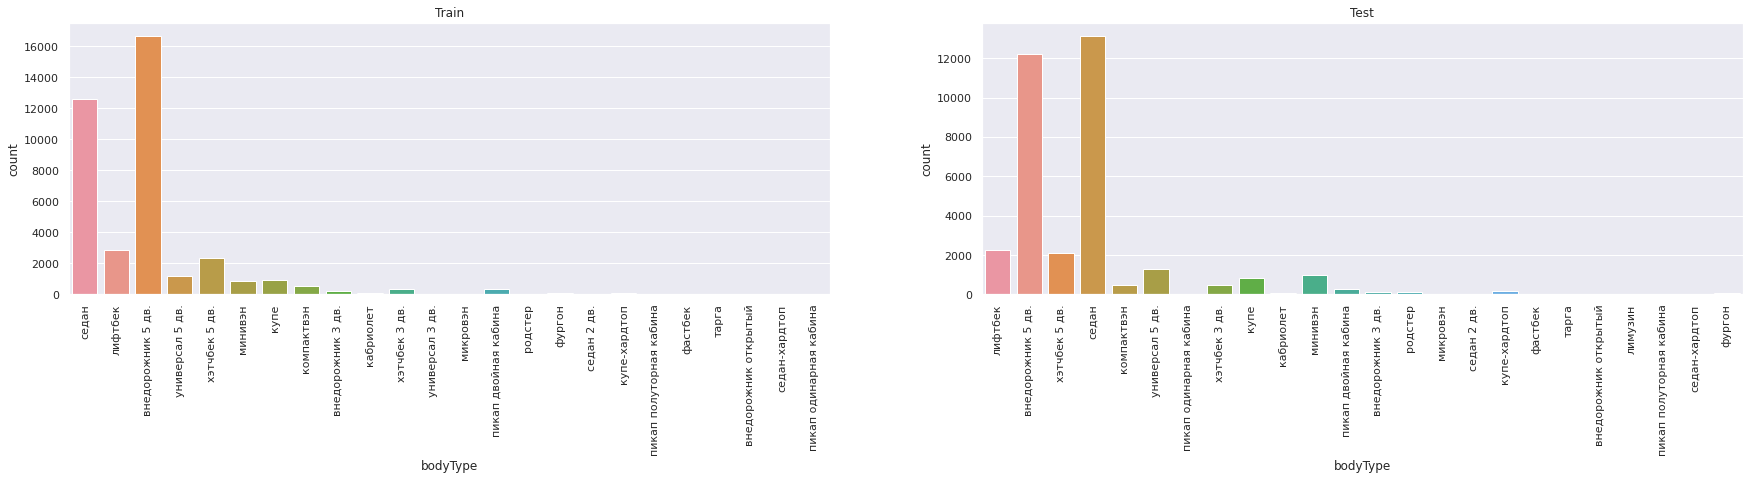

In [22]:
fig, ax =plt.subplots(1,2, figsize=(30,5))
sns.countplot(x='bodyType', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='bodyType', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

Признак категориальный. В test преобладают седаны, в то время как в train - внедорожники

### brand - Марка автомобиля

Категориальный признак, перечень марок совпадает


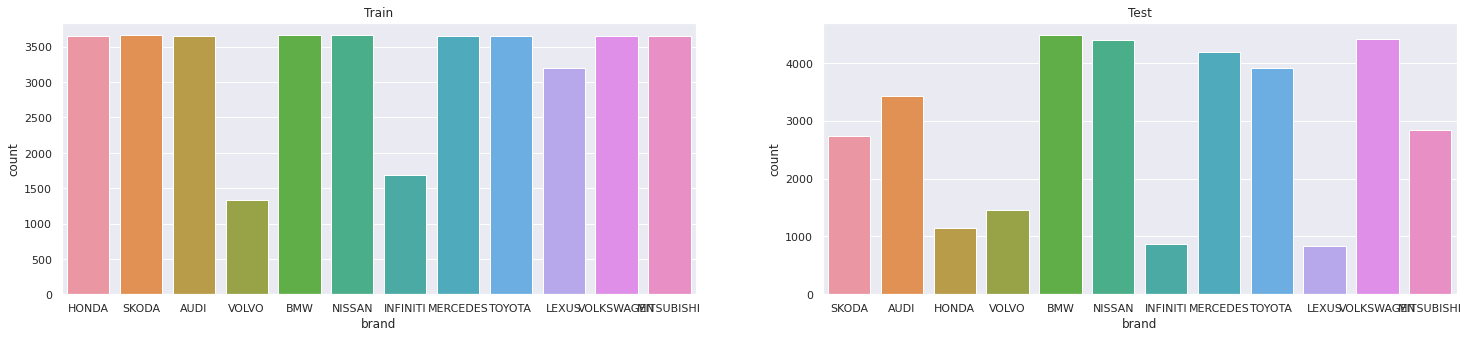

In [23]:
fig, ax =plt.subplots(1,2, figsize=(25,5))
sns.countplot(x='brand', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='brand', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

В train данные по некоторым маркам как-будто обрезаны. Это связано с тем, что выгрузка производилась по маркам автомобилей, а auto.ru лимитирует выдачу по маркам 99-ю страницами.

Посмотрим на распределение целевой переменной по маркам авто

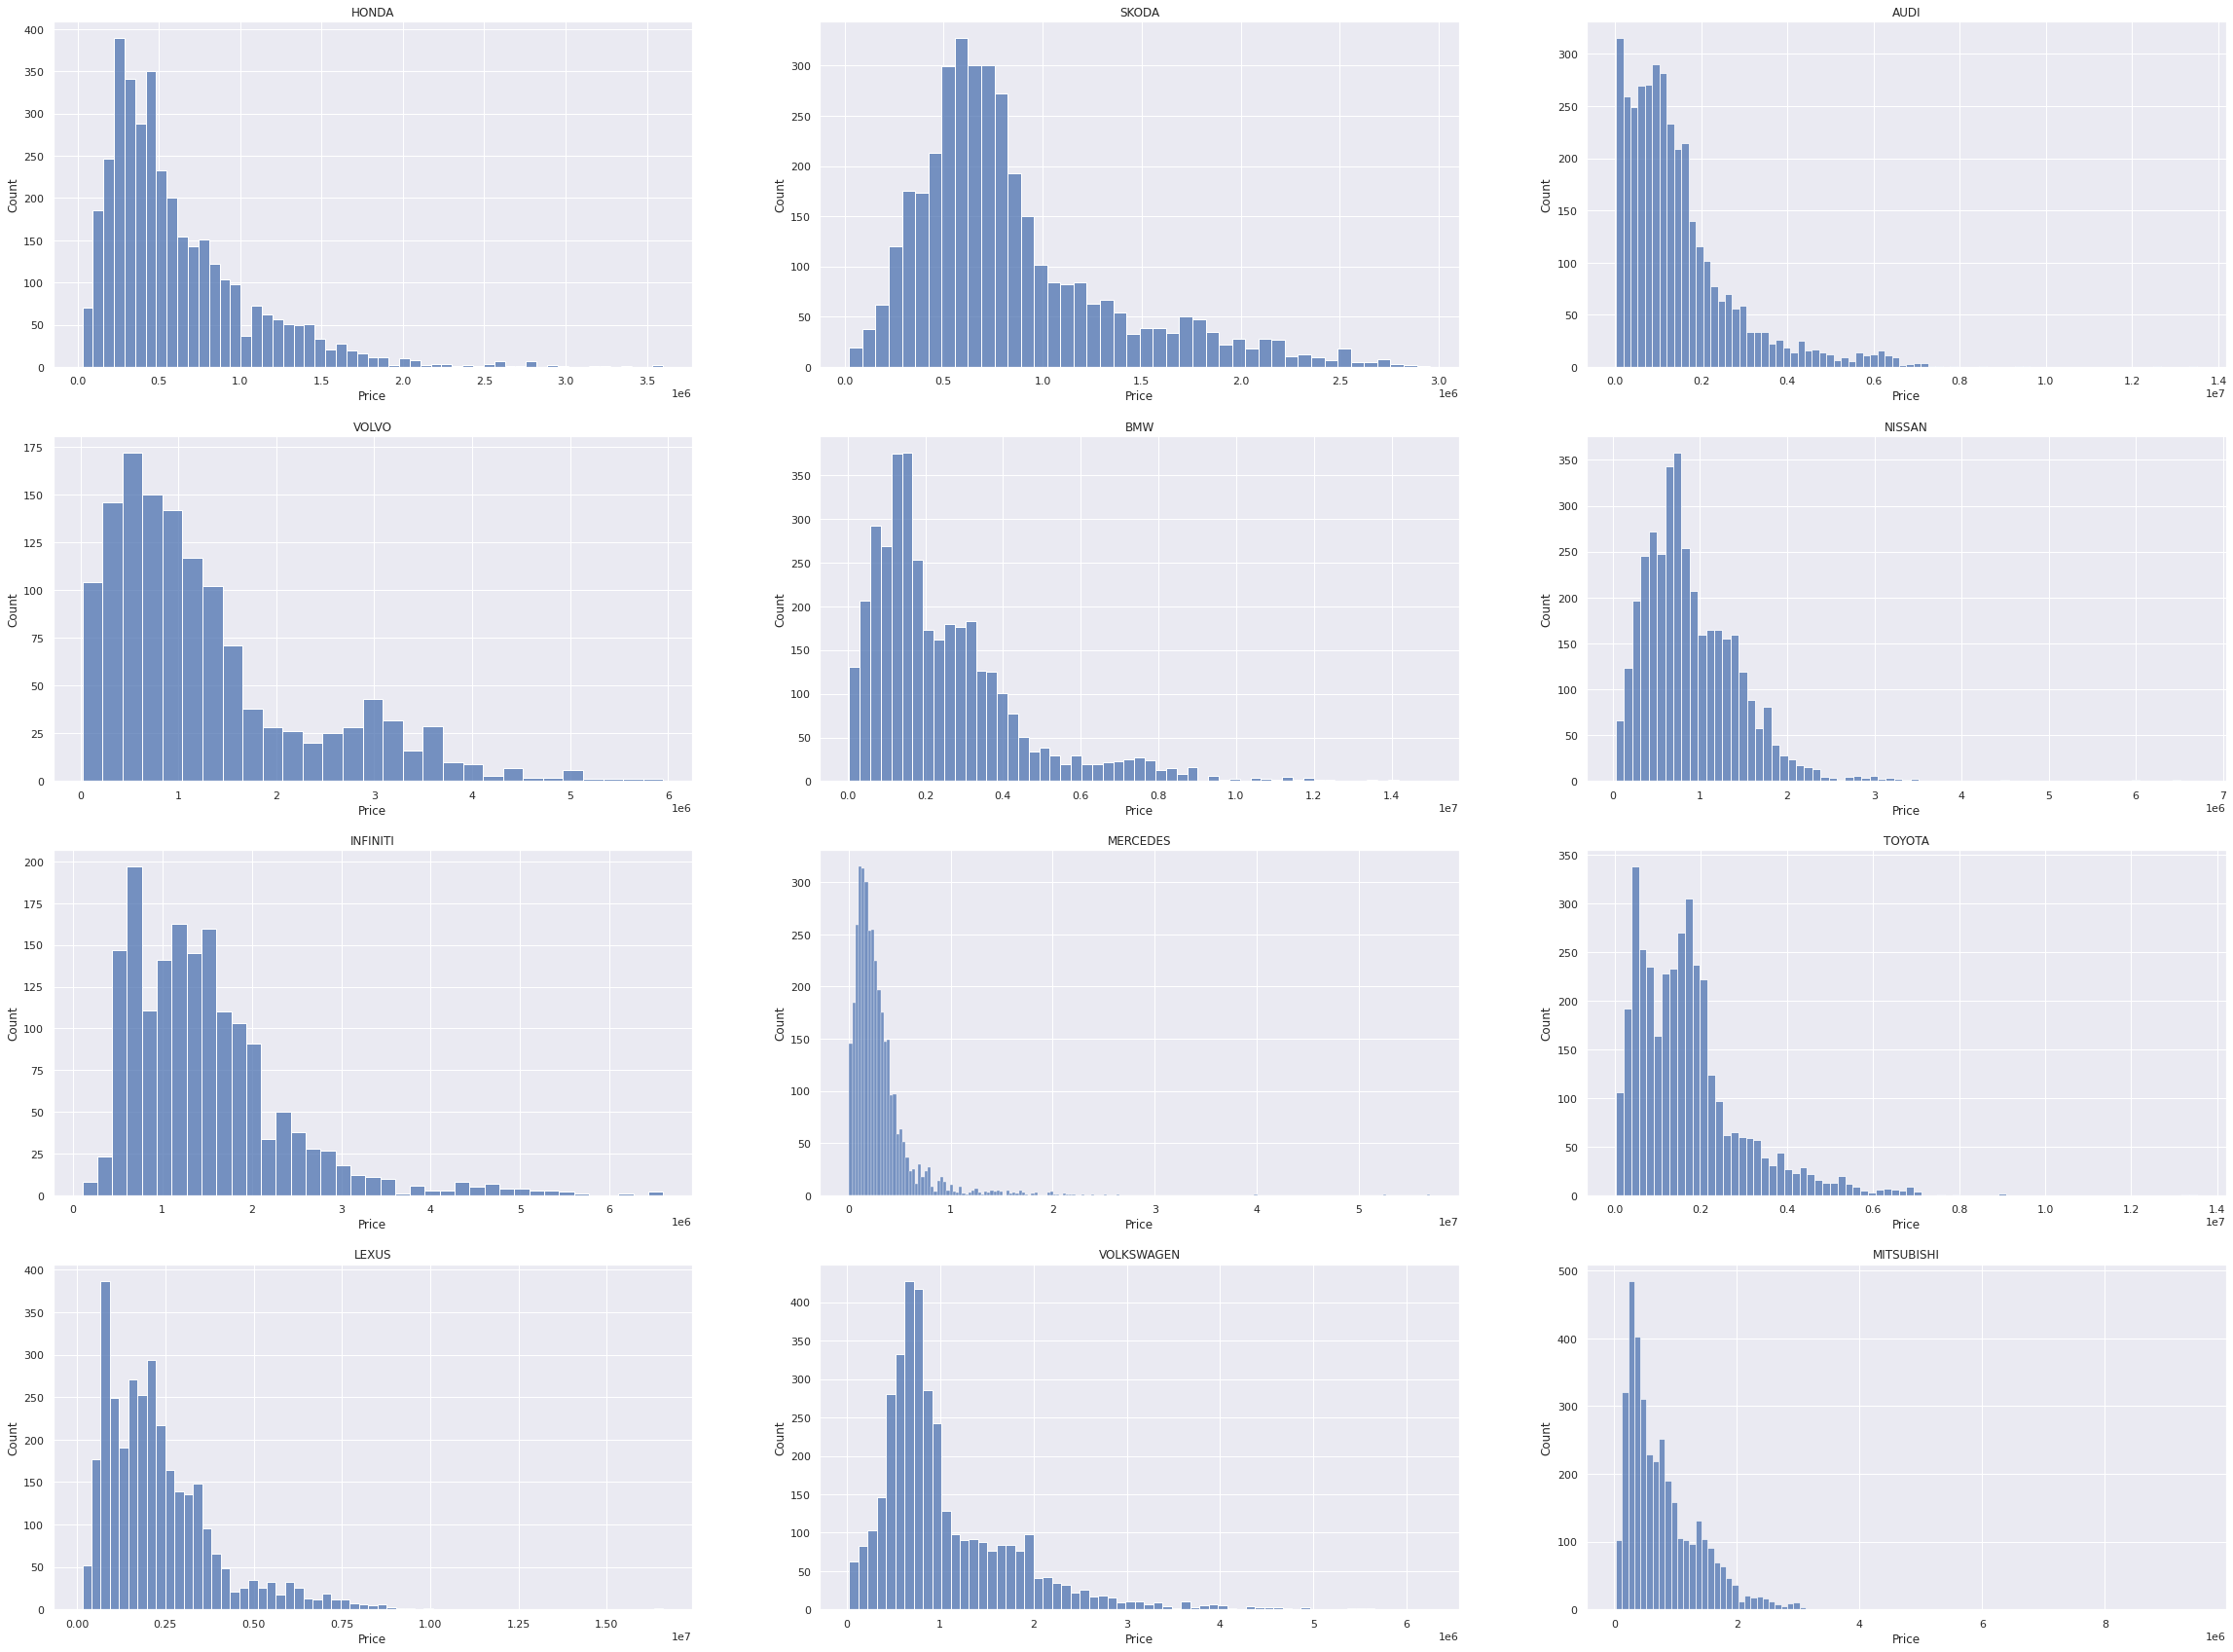

In [24]:
fig, ax = plt.subplots(4,3, figsize=(40,30))
for i in range(4):
    for j in range(3):
        sns.histplot(x = train.Price[train.brand==train.brand.unique()[i*3+j]], ax=ax[i,j])
        ax[i,j].set_title(train.brand.unique()[i*3+j])
fig.show()          



Правые хвосты предположительно связаны с наличием в выдаче б/у автомобилей новых машин с высокой ценой, которые автосалоны выставляют на продажу как б/у.
На выбросы надо посмотреть отдельно.

In [25]:
outliers = train[
    (train.Price <= train_stats[train_stats.feature_name=='Price'].iloc[0]['l_border']) |
    (train.Price >= train_stats[train_stats.feature_name=='Price'].iloc[0]['r_border'])
]

In [26]:
outliers

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,Price
5,лифтбек,AUDI,https://auto.ru/cars/used/sale/audi/a7/1102646...,серый,#cme600-0b6e02ff-7a68-11eb-be32-000c29224324Со...,3.0,249,"['body-kit', 'alloy-wheel-disks', 'eco-leather...",дизель,3518.000000,2018,A7,45 TDI 3.0d AT (249 л.с.) 4WD,5,2020,автоматическая,EUROPEAN,2,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5870000
11,внедорожник 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/sq7/110282...,серый,Только из Германии ! Состояние на 30/40 тысяч ...,4.0,435,[],дизель,126800.000000,2016,SQ7,4.0d AT (435 л.с.) 4WD,5,2017,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4499000
23,внедорожник 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/q8/1102460...,чёрный,✅ Состояние нового автомобиля✅ ПТС оригинал✅ 1...,3.0,340,"['asr', 'airbag-driver', 'hsa', 'airbag-curtai...",бензин,72000.000000,2018,Q8,55 TFSI 3.0 AT (340 л.с.) 4WD,5,2019,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5700000
56,седан,AUDI,https://auto.ru/cars/used/sale/audi/a6/1102265...,чёрный,- Наш автосалон обеспечивает максимальную безо...,2.0,245,"['cruise-control', 'multi-wheel', 'active-stee...",бензин,10195.000000,2018,A6,45 TFSI 2.0 AMT (245 л.с.) 4WD,4,2019,роботизированная,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,3950000
74,внедорожник 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/q8/1102478...,белый,Ваш выбор и Ваше время — наши главные приорите...,3.0,249,"['asr', 'airbag-driver', 'airbag-passenger', '...",дизель,5859.000000,2018,Q8,45 TDI 3.0d AT (249 л.с.) 4WD,5,2019,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5730000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38674,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,синий,💸Выгода до 100 000 рублей при покупке в кредит...,2.0,249,"['asr', 'esp', 'airbag-passenger', 'bas', 'kne...",бензин,42840.750000,2018,TOUAREG,2.0 AT (249 л.с.) 4WD,5,2018,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,3797000
38679,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,бежевый,- В наличие более 300 автомобилей!- Гарантиров...,3.0,249,"['cruise-control', 'multizone-climate-control'...",дизель,42840.750000,2018,TOUAREG,3.0d AT (249 л.с.) 4WD,5,2018,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4045220
38895,минивэн,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/mult...,чёрный,IDКомплектация-- Автомобиль прошел комплексную...,2.0,180,"['engine-proof', 'spare-wheel', 'asr', 'esp', ...",дизель,142835.000000,2015,MULTIVAN,2.0d AMT (180 л.с.) 4WD,4,2015,роботизированная,EUROPEAN,2,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4399000
39022,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,коричневый,Ваш выбор и Ваше время — наши главные приорите...,3.0,249,['leather'],дизель,42840.750000,2018,TOUAREG,3.0d AT (249 л.с.) 4WD,5,2018,автоматическая,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4899000


In [27]:
outliers.brand.unique()

array(['AUDI', 'BMW', 'VOLVO', 'NISSAN', 'INFINITI', 'MERCEDES', 'TOYOTA',
       'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'], dtype=object)

Посмотрим автомобили каких годов выпуска вышли по цене за 1,5 межквартильных расстояния от 1 и 3 квартилей

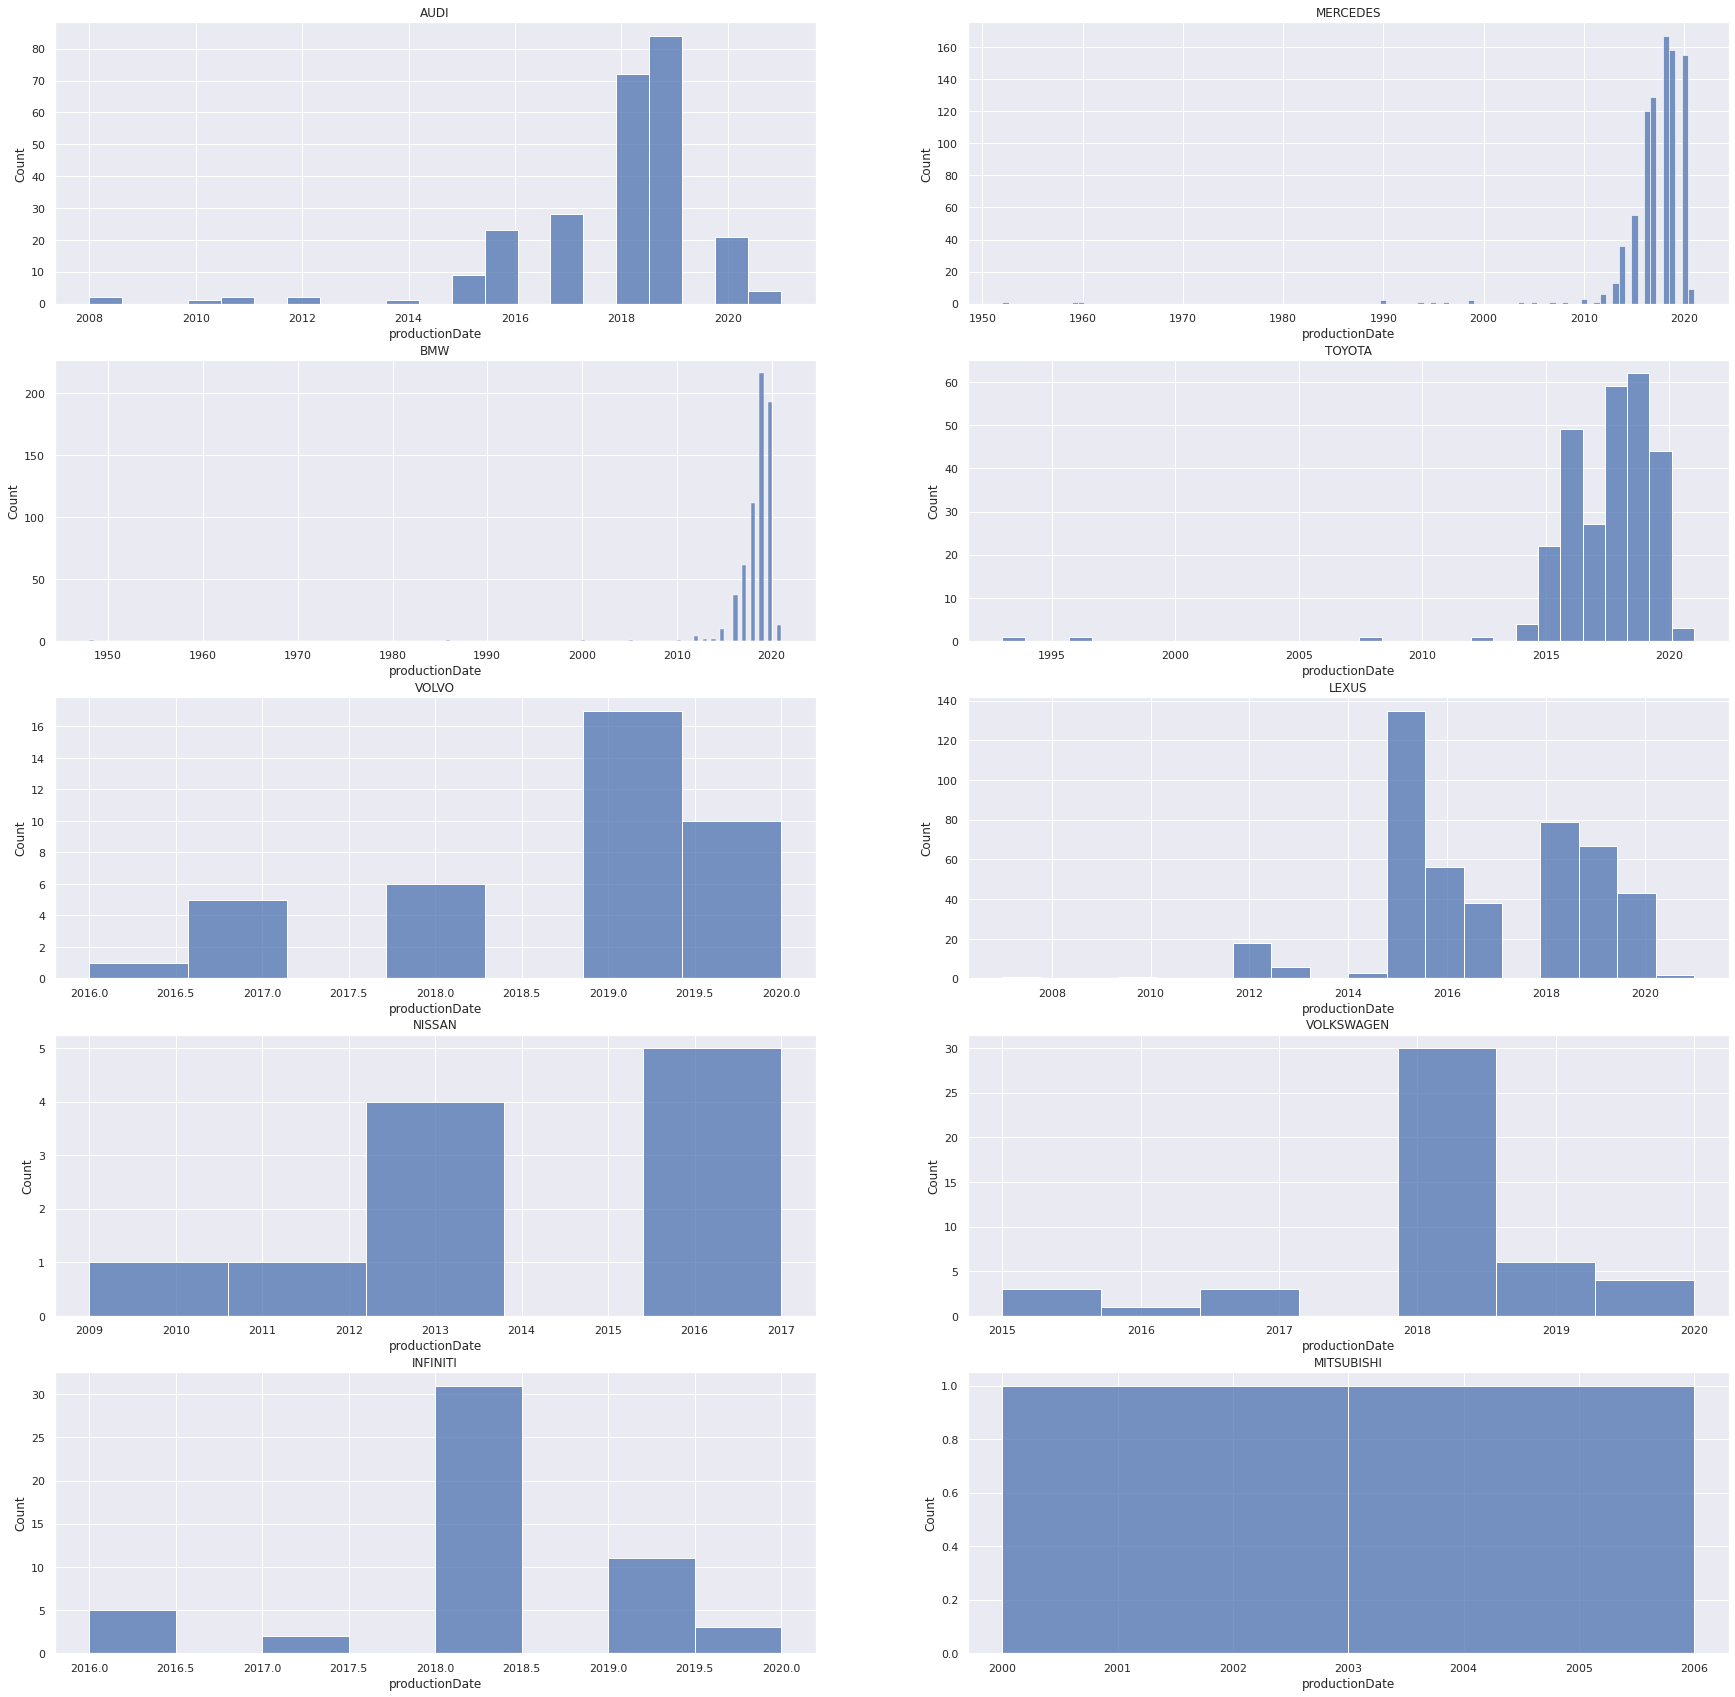

In [28]:
fig, ax = plt.subplots(5,2, figsize=(30,30))
for i in range(5):
    for j in range(2):
        #print(i, j, i+j, train.brand.unique()[i*5+j])
        sns.histplot(x = outliers.productionDate[outliers.brand==outliers.brand.unique()[i+j*5]], ax=ax[i,j])
        ax[i,j].set_title(outliers.brand.unique()[i+j*5])
fig.show()   

Проверим AUDI, MERCEDES, BMW, TOYOTA, LEXUS, NISSAN у остальных марок год выпуска для дорогих автомобилей кажется приемлемым

In [29]:
outliers[outliers['brand'].isin(['AUDI', 'MERCEDES', 'BMW', 'TOYOTA', 'LEXUS', 'NISSAN']) & (outliers.productionDate<=2010)]

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,Price
2035,кабриолет,AUDI,https://auto.ru/cars/used/sale/audi/r8/1102811...,красный,Полный ЭксклюзивЕдинственная в РоссииКуплена п...,5.2,525,"['asr', 'esp', 'lane-keeping-assist', 'airbag-...",бензин,33000.0,2007,R8,V10 5.2 AMT (525 л.с.) 4WD,2,2010,роботизированная,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,6500000
2211,купе,AUDI,https://auto.ru/cars/used/sale/audi/r8/1100775...,белый,"Стоит двигатель (5.2), коробка и трансмиссия о...",5.2,525,"['alloy-wheel-disks', 'rain-sensor', 'light-se...",бензин,42100.0,2007,R8,V10 5.2 AMT (525 л.с.) 4WD,2,2008,роботизированная,EUROPEAN,3,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,3999000
2225,купе,AUDI,https://auto.ru/cars/used/sale/audi/r8/1102702...,белый,Отличное состояние.В залогах и т.д. не числитс...,4.2,420,"['esp', 'airbag-driver', 'airbag-side', 'airba...",бензин,13860.0,2007,R8,V8 4.2 AMT (420 л.с.) 4WD,2,2008,роботизированная,EUROPEAN,1,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,4500000
10574,седан 2 дв.,BMW,https://auto.ru/cars/used/sale/bmw/321/1092197...,коричневый,"1948 BMW 3216-цилиндровый двухдверный седан, в...",2.0,46,[],бензин,10.0,1937,321,2.0 MT (46 л.с.),2,1948,механическая,EUROPEAN,3,85.0,Оригинал,задний,Левый,Не требует ремонта,Растаможен,5000000
12592,купе,BMW,https://auto.ru/cars/used/sale/bmw/m3/10859807...,серый,"Полный сток в коллекционном состоянии ,цвет за...",4.0,420,"['cruise-control', 'multi-wheel', 'ashtray-and...",бензин,25500.0,2007,M3,4.0 AMT (420 л.с.),2,2010,роботизированная,EUROPEAN,2,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3999000
12807,седан,BMW,https://auto.ru/cars/used/sale/bmw/7er/1102808...,голубой,"Автомобиль не бит, не крашен. Все в оригинале....",3.4,192,"['electro-window-back', 'cruise-control', 'ele...",бензин,60000.0,1977,7ER,735i 3.4 AT (192 л.с.),4,1986,автоматическая,EUROPEAN,1,6.0,Оригинал,задний,Левый,Не требует ремонта,Растаможен,4000000
13243,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x5/11019046...,чёрный,Предложение для коллекционеров и ценителей дан...,3.0,231,[],бензин,156000.0,2003,X5,3.0i 3.0 AT (231 л.с.) 4WD,5,2005,автоматическая,EUROPEAN,2,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5000000
13952,кабриолет,BMW,https://auto.ru/cars/used/sale/bmw/z8/11023067...,серый,"Идеальное состояние, исключительно летняя эксп...",4.9,400,[],бензин,63000.0,2000,Z8,4.9 MT (400 л.с.),2,2000,механическая,EUROPEAN,2,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,13900000
17493,купе,NISSAN,https://auto.ru/cars/used/sale/nissan/gt_r/108...,белый,GTR-R35 GTT1000 1200+ HPПроект был создан в ко...,3.8,480,"['cruise-control', 'electro-window-front', 'co...",бензин,18000.0,2007,GT_R,3.8 AMT (480 л.с.) 4WD,2,2009,роботизированная,JAPANESE,1,74.0,Оригинал,полный,Левый,Не требует ремонта,Растаможен,6150000
20617,внедорожник 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/g_klas...,чёрный,ЗАВОДСКОЙ БРОНИРОВАННЫЙ АВТОМОБИЛЬ КЛАССА В6ОТ...,5.0,296,"['cruise-control', 'e-adjustment-wheel', 'mult...",бензин,102222.0,1990,G_KLASSE,500 5.0 AT (296 л.с.) 4WD,5,2005,автоматическая,EUROPEAN,3,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5200000


Ну вроде все в порядке - в основном эксклюзивные машины, есть несколько завышенных цен, но удалять их руками не будем.

### car_url - Ссылка на страницу объявления. Убираем.

### color - цвет автомобиля

In [30]:
sorted(test.color.unique())

['бежевый',
 'белый',
 'голубой',
 'жёлтый',
 'зелёный',
 'золотистый',
 'коричневый',
 'красный',
 'оранжевый',
 'пурпурный',
 'розовый',
 'серебристый',
 'серый',
 'синий',
 'фиолетовый',
 'чёрный']

In [31]:
sorted(train.color.unique())

['бежевый',
 'белый',
 'голубой',
 'жёлтый',
 'зелёный',
 'золотистый',
 'коричневый',
 'красный',
 'оранжевый',
 'пурпурный',
 'розовый',
 'серебристый',
 'серый',
 'синий',
 'фиолетовый',
 'чёрный']

Категориальный признак. Список цветов идентичен в train и test

<AxesSubplot:xlabel='color', ylabel='count'>

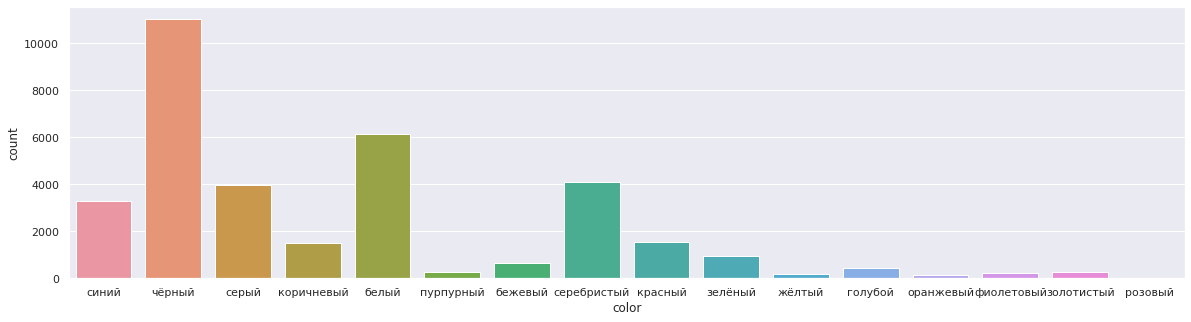

In [32]:
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x='color', ax=ax, data=test)

### complectation_dict в test
Выглядит как комплектация модели автомобиля. В признаке слишком много пропусков. Убираем

### description - Текстовые комментарии к объявлению
Может быть полезен, но надо применять анализ текста. Например для выявления типа продавца - частное лицо или автосалон

### engineDisplacement - Объем двигателя

In [33]:
sorted(train.engineDisplacement.unique())

[0.0,
 0.7,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0,
 2.1,
 2.2,
 2.3,
 2.4,
 2.5,
 2.6,
 2.7,
 2.8,
 2.9,
 3.0,
 3.1,
 3.2,
 3.3,
 3.4,
 3.5,
 3.6,
 3.7,
 3.8,
 3.9,
 4.0,
 4.1,
 4.2,
 4.3,
 4.4,
 4.5,
 4.6,
 4.7,
 4.8,
 4.9,
 5.0,
 5.2,
 5.4,
 5.5,
 5.6,
 5.7,
 5.8,
 5.9,
 6.0,
 6.2,
 6.3,
 6.6]

Признак по происхождению числовой. Но по сути категориальный.

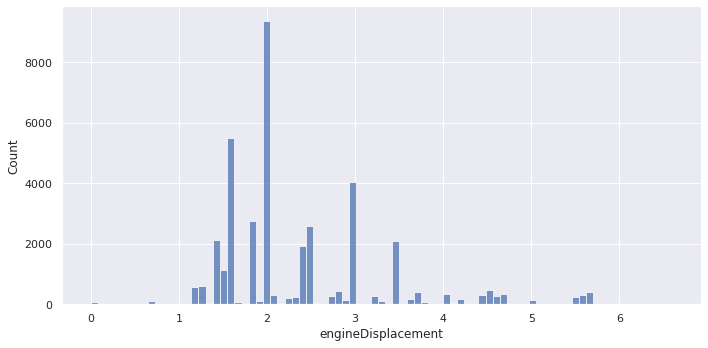

In [34]:
sns.displot(x = train.engineDisplacement, kde = False, rug=False, height=5, aspect=2)

Видны популярные размеры двигателей 1.5, 2.0, 3.0

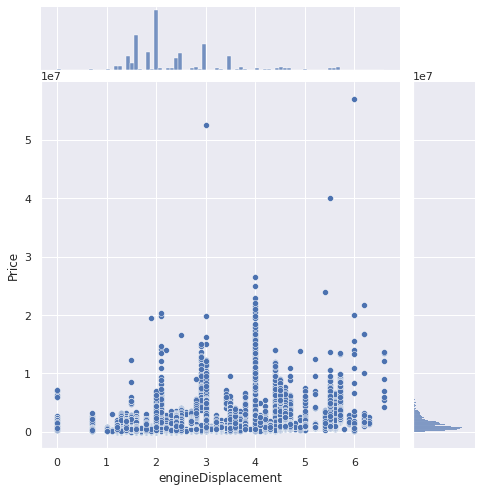

In [35]:
sns.jointplot(x='engineDisplacement', y='Price', data=train, kind='scatter', height=7)

### enginePower - Мощность двигателя

Признак числовой. Распределение смещено. Что объяснимо наибольшей популярностью авто с мощностью от 100 до 200

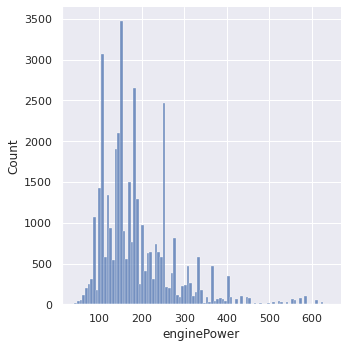

In [36]:
sns.displot(x = train.enginePower, kde = False, rug=False)

Преобладают авто с мощностью от 100 до 200 л.с. И виден "налоговый" пик в 249 л.с., после которого резко повышается ставка налога на автомобиль. Автопроизводители искусствено ограничивают мощность двигателей на этом уровне.
Посмотрим на взаимосвязь цены и мощности.

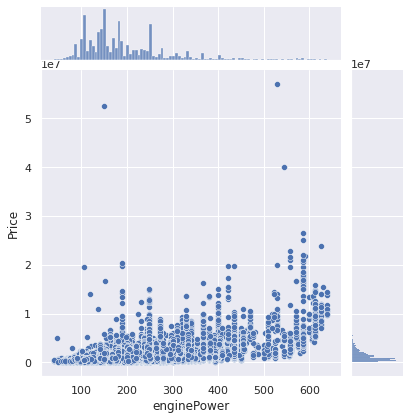

In [37]:
sns.jointplot(x='enginePower', y='Price', data=train, kind='scatter')

Ожидал увидеть более линейную зависимость. 

### equipment_dict - Словарь с оборудованием автомобиля
В test выглядит как словарь, в train уже обработан в виде списка оборудования. Будем словарь преобразовывать в список, а из списка делать dummy-переменные

### fuelType - Тип топлива

In [38]:
sorted(train.fuelType.unique())

['бензин', 'газ', 'гибрид', 'дизель', 'электро']

In [39]:
sorted(test.fuelType.unique())

['бензин', 'газ', 'гибрид', 'дизель', 'электро']

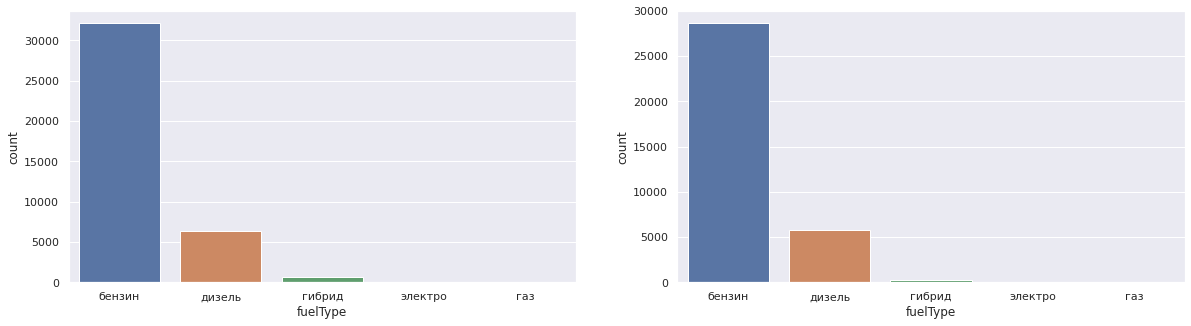

In [40]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='fuelType', data=train, ax=ax[0])
sns.countplot(x='fuelType', data=test, ax=ax[1])
fig.show()


Признак категориальный. Соотношение автомобилей по типу топлива одинаковое

### mileage - пробег

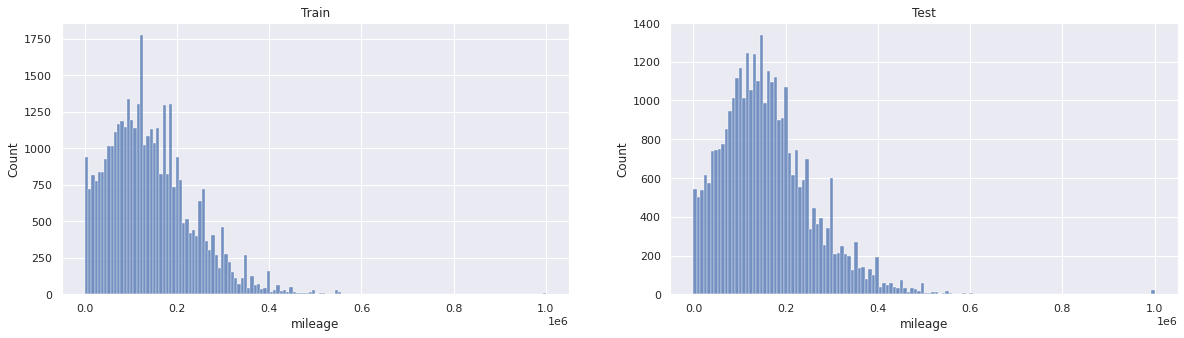

In [41]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.histplot(x='mileage', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.histplot(x='mileage', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Числовой признак. Распределение смещено. Преобладают авто с пробегом от 80 до 150 тыс. км.

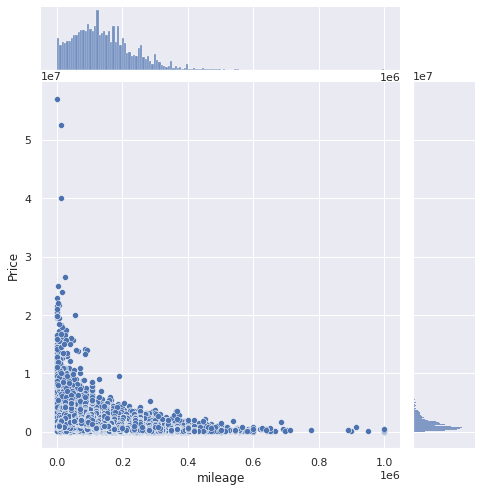

In [42]:
sns.jointplot(x='mileage', y='Price', data=train, kind='scatter', height=7)

Ну для этого признака взаимосвязь пробега и цены более наглядна, чем для мощности. Зависимость похожа на 1/x.

### modelDate - Дата выхода модели в продажу

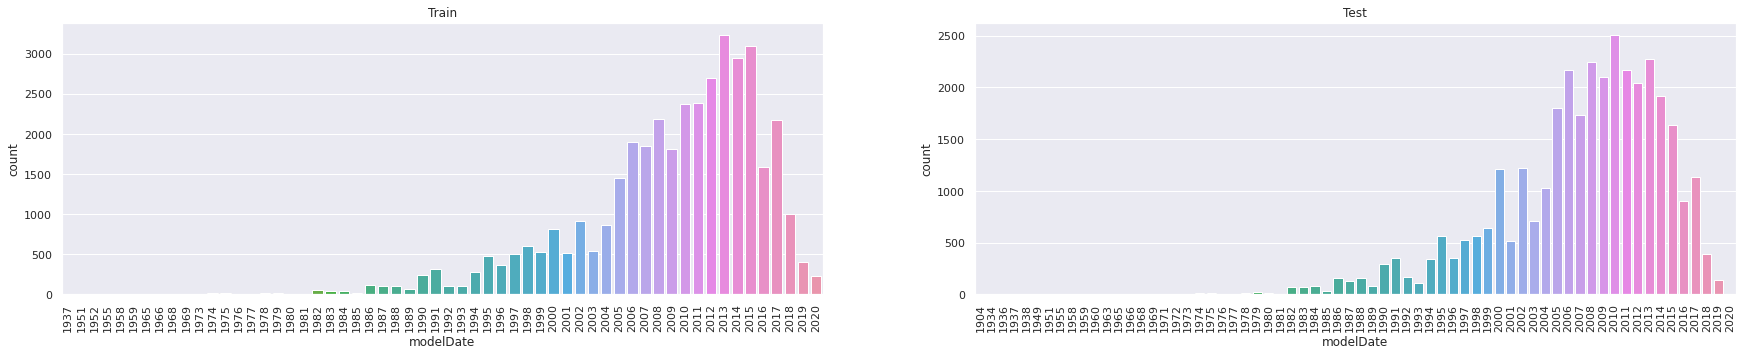

In [43]:
fig, ax =plt.subplots(1,2, figsize=(30,5))
sns.countplot(x='modelDate', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='modelDate', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

Признак больше категориальный, чем числовой. Распределения одинаковы в train и test
Посмотрим на связь с ценой

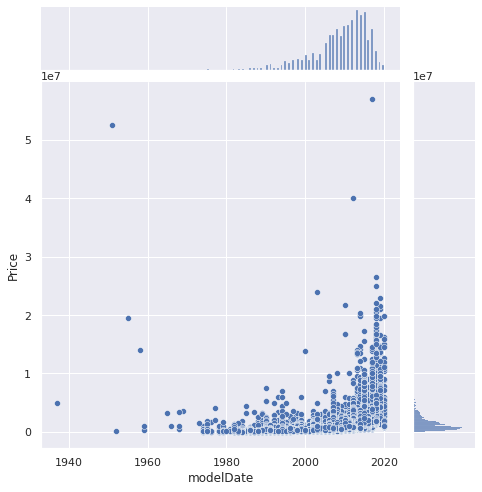

In [44]:
sns.jointplot(x='modelDate', y='Price', data=train, kind='scatter', height=7)

Тут все более-менее закономерно, чем позднее модель, тем она и дороже

### model_info

test.model_info - выглядит как некий справочник по моделям, в train выгрузке отсутствует. Убираем

### model_name

Просто название автомобиля. Категориальный. 544 уникальных в test, 540 в train

In [45]:
print(len(test.model_name.unique()))
print(len(train.model_name.unique()))

544
540


### name

Новой информации не несет, является совокупностью значений признаков модели авто, трансмиссии, мощности двигателя и привода. Убираем

### numberOfDoors - количество дверей

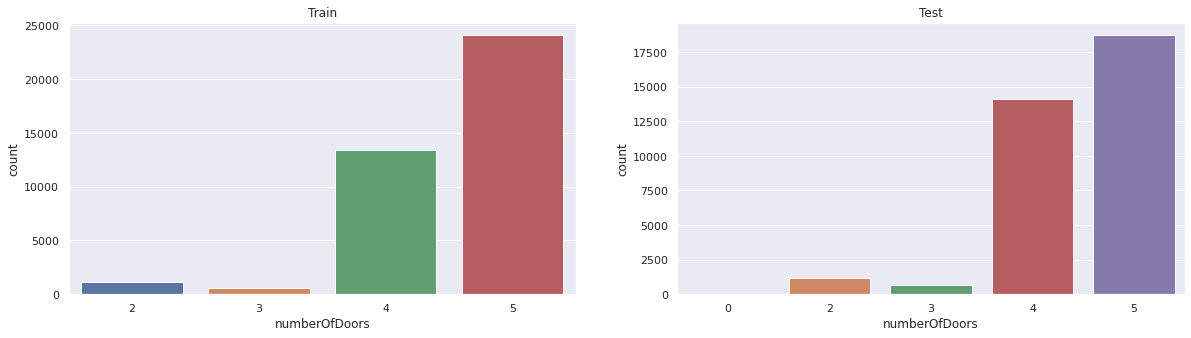

In [46]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='numberOfDoors', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='numberOfDoors', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Распределение признаков в train и test совпадает

### parsing_unixtime

Время парсинга датасета в формате unixtime. Убираем

### priceCurrency

Валюта объявления. Все объявления в рублях. Убираем

### productionDate - Дата производства автомобиля

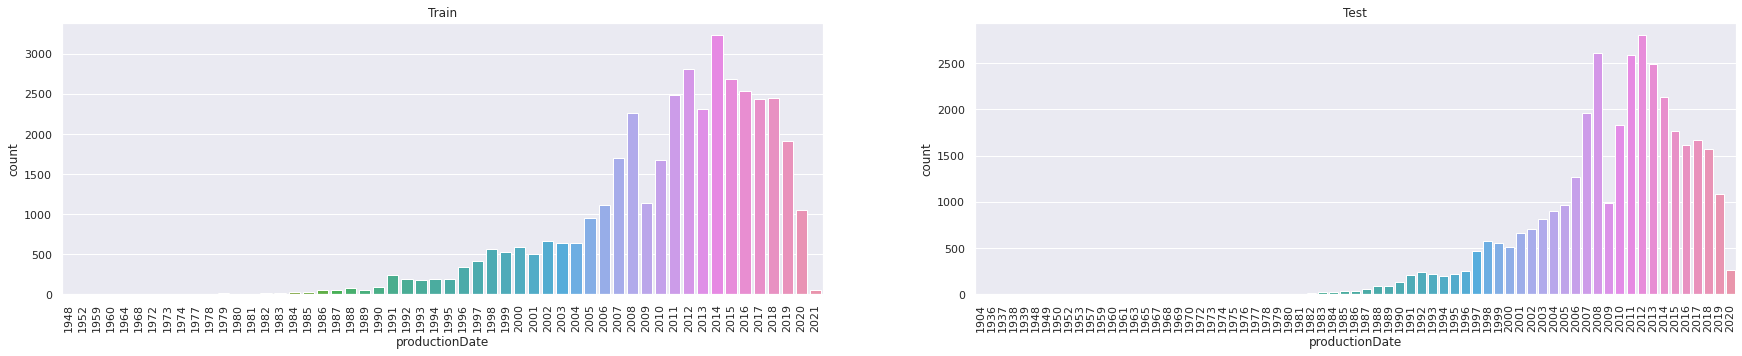

In [47]:
fig, ax =plt.subplots(1,2, figsize=(30,5))

sns.countplot(x='productionDate', data=train, ax=ax[0])
ax[0].set_title('Train')
ax[0].tick_params(axis='x', labelrotation=90)
sns.countplot(x='productionDate', data=test, ax=ax[1])
ax[1].set_title('Test')
ax[1].tick_params(axis='x', labelrotation=90)
fig.show()

Признак больше категориальный, чем числовой. Распределения в test и train похожи. Заметен значимый провал кризисного 2009 года.

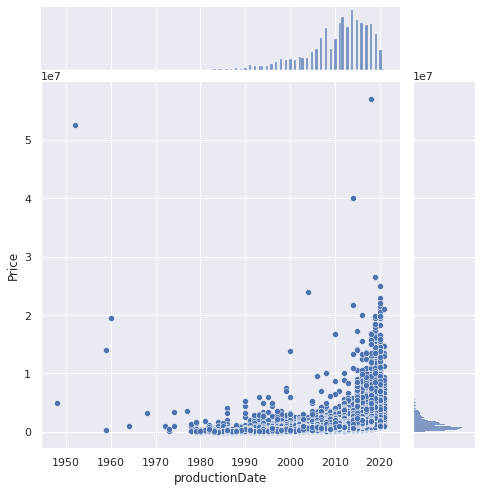

In [48]:
sns.jointplot(x='productionDate', y='Price', data=train, kind='scatter', height=7)

Взаимосвязь цены и года выпуска авто логичная. Выбросы уже проанализированы.

### sell_id

Какой-то идентификатор объявления. Информации не несет. Убираем

### super_gen

test.super_gen[0]

> '{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

очередной справочник с привязкой к id. Можно было бы извлекать информацию, но пропусков в датасете вроде и нет. Убираем.

### vehicleConfiguration

test.vehicleConfiguration[2]
> 'LIFTBACK ROBOT 1.8'

Признак дублирует имеющуюся информацию. Убираем.

### vehicleTransmission - привод автомобиля

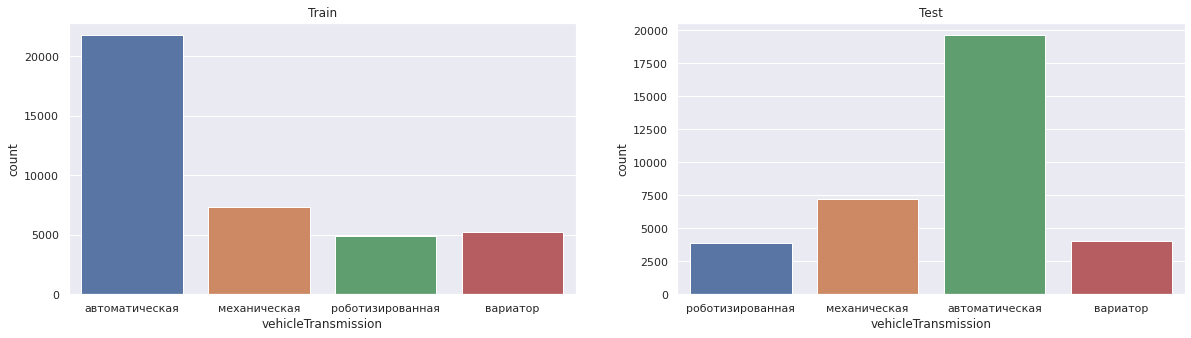

In [49]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='vehicleTransmission', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='vehicleTransmission', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Распределение признака в train и test совпадает

vendor

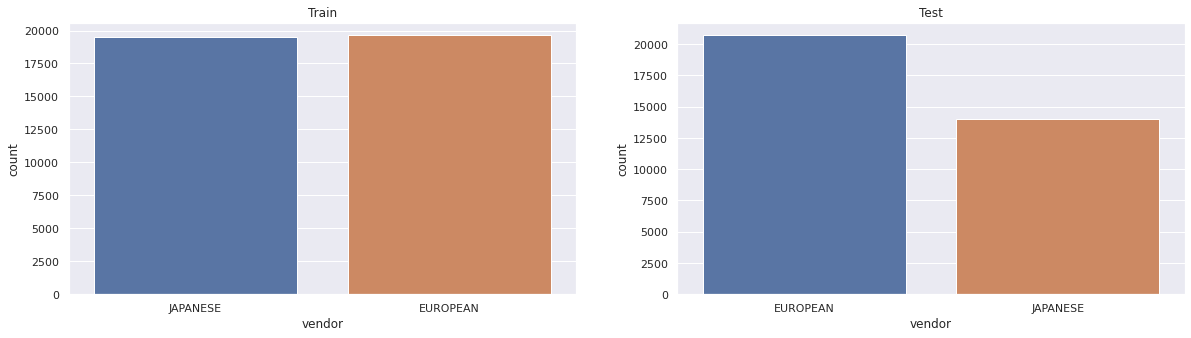

In [50]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='vendor', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='vendor', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Бинарный признак. В test японских автомобилей меньше, чем европейских

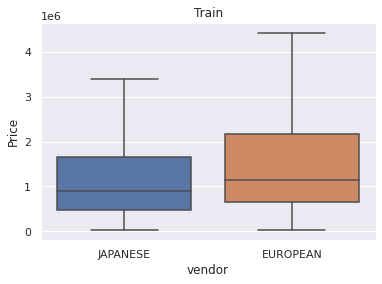

In [51]:
sns.boxplot(x='vendor', y= 'Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Европейские автомобили дороже

### Владельцы

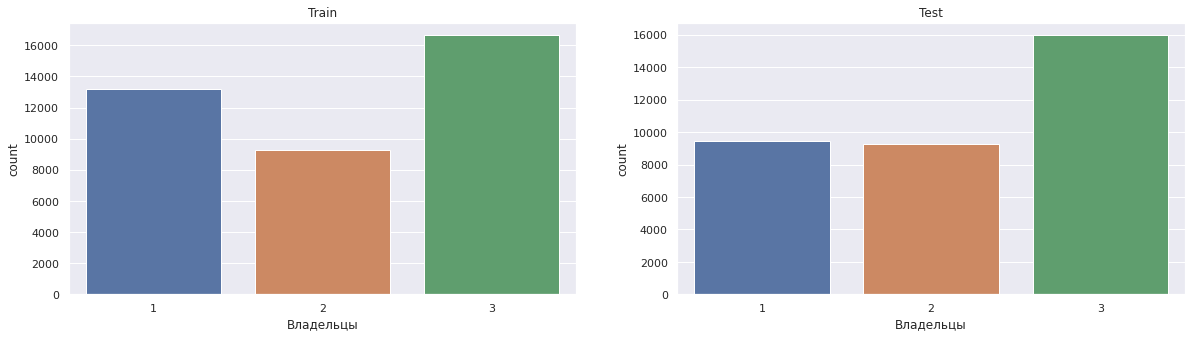

In [52]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='Владельцы', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='Владельцы', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Категориальный признак. Картина по датасетам приблизительно одинаковая

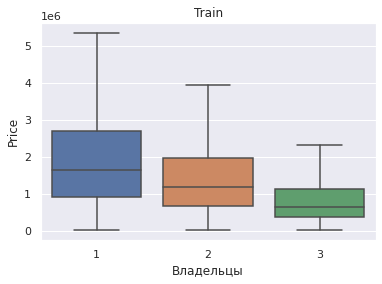

In [53]:
sns.boxplot(x='Владельцы', y= 'Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Влияние на цену количества владельцев - явно выражено

### Владение

Слишком много пропусков. Убираем.

### ПТС

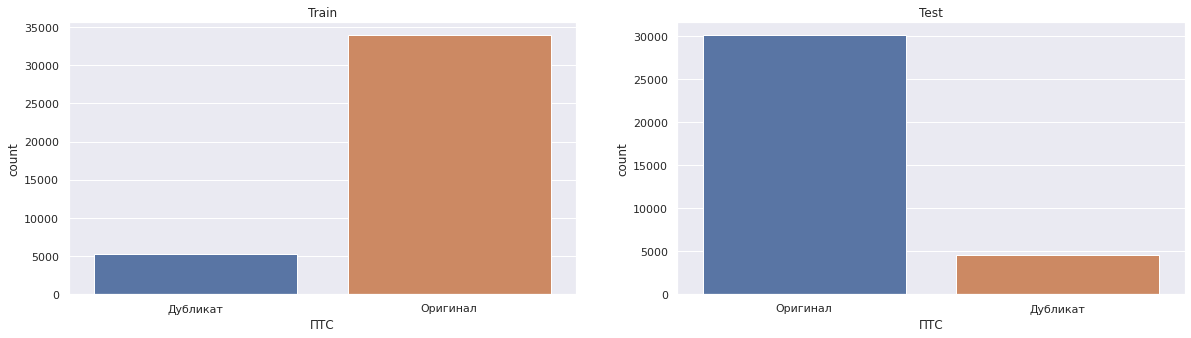

In [54]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='ПТС', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='ПТС', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Бинарный признак. В обоих датасетах преобладает большинство авто с оригиналом ПТС

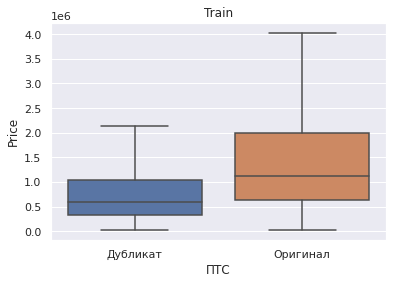

In [55]:
sns.boxplot(x='ПТС', y= 'Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Машины с дубликатами ПТС сильно дешевле. Но скорее всего и старше по возрасту.

### Привод

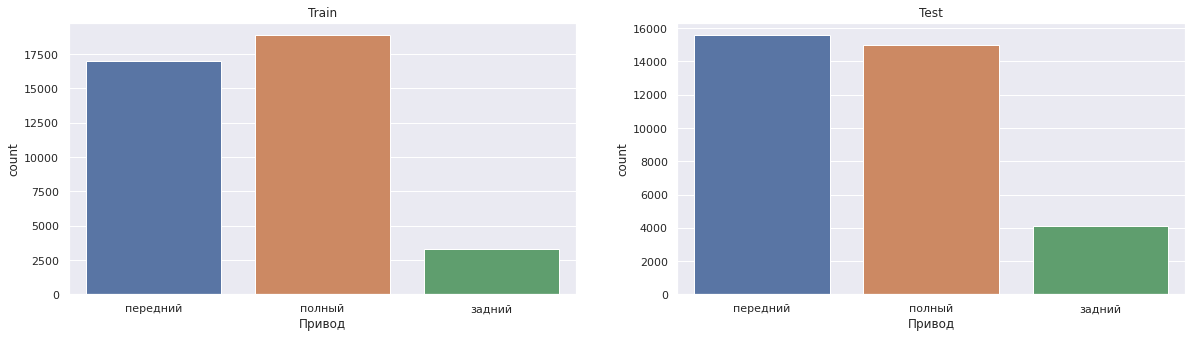

In [56]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='Привод', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='Привод', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Признак категориальный, распределение приблизительно одинаковое. Заднеприводные авто в меньшинстве.

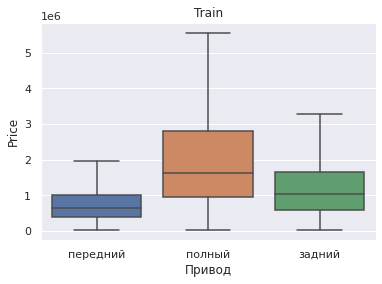

In [57]:
sns.boxplot(x='Привод', y= 'Price', data=train, showfliers=False)
plt.title('Train')
plt.show()

Полноприводные машины дороже. Переднеприводные - дешевый и массовый сегмент.

### Руль

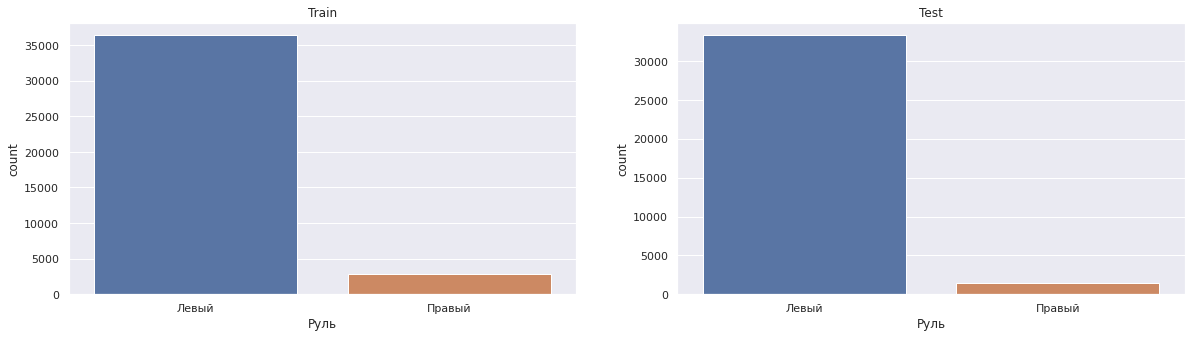

In [58]:
fig, ax =plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='Руль', data=train, ax=ax[0])
ax[0].set_title('Train')
sns.countplot(x='Руль', data=test, ax=ax[1])
ax[1].set_title('Test')
fig.show()

Признак бинарный. Картина по датасетам одинаковая.

### Состояние

Весь признак имеет одинаковое значение 'Не требует ремонта'
Убираем

### Таможня

Весь признак имеет одинаковое значение 'Растаможен'.
Убираем.

## Data Preprocessing

### Preprocessing

In [59]:
# Конвертируем текстовый признак c опциями в список 
train.equipment_dict = train.equipment_dict.apply(lambda x: clear_text_list(x))

In [60]:
# Объединим датасеты, предварительно пометив train и test
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['Price'] = 0 # в тесте у нас нет значения Price, заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73822 entries, 0 to 73821
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             73822 non-null  object 
 1   brand                73822 non-null  object 
 2   car_url              73822 non-null  object 
 3   color                73822 non-null  object 
 4   description          72955 non-null  object 
 5   engineDisplacement   73822 non-null  float64
 6   enginePower          73822 non-null  int64  
 7   equipment_dict       73822 non-null  object 
 8   fuelType             73822 non-null  object 
 9   mileage              73822 non-null  float64
 10  modelDate            73822 non-null  int64  
 11  model_name           73822 non-null  object 
 12  name                 73822 non-null  object 
 13  numberOfDoors        73822 non-null  int64  
 14  productionDate       73822 non-null  int64  
 15  vehicleTransmission  73822 non-null 

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73822 entries, 0 to 73821
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             73822 non-null  object 
 1   brand                73822 non-null  object 
 2   car_url              73822 non-null  object 
 3   color                73822 non-null  object 
 4   description          72955 non-null  object 
 5   engineDisplacement   73822 non-null  float64
 6   enginePower          73822 non-null  int64  
 7   equipment_dict       73822 non-null  object 
 8   fuelType             73822 non-null  object 
 9   mileage              73822 non-null  float64
 10  modelDate            73822 non-null  int64  
 11  model_name           73822 non-null  object 
 12  name                 73822 non-null  object 
 13  numberOfDoors        73822 non-null  int64  
 14  productionDate       73822 non-null  int64  
 15  vehicleTransmission  73822 non-null 

In [63]:
# Разделим features по типу

num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate' ]
    
bin_cols = ['vendor', 'ПТС', 'Руль']
       
cat_cols = ['bodyType', 'brand','color', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Владельцы',  'Привод']

len(num_cols)+len(bin_cols)+len(cat_cols)

17

Посмотрим на корреляцию числовых признаков

<AxesSubplot:>

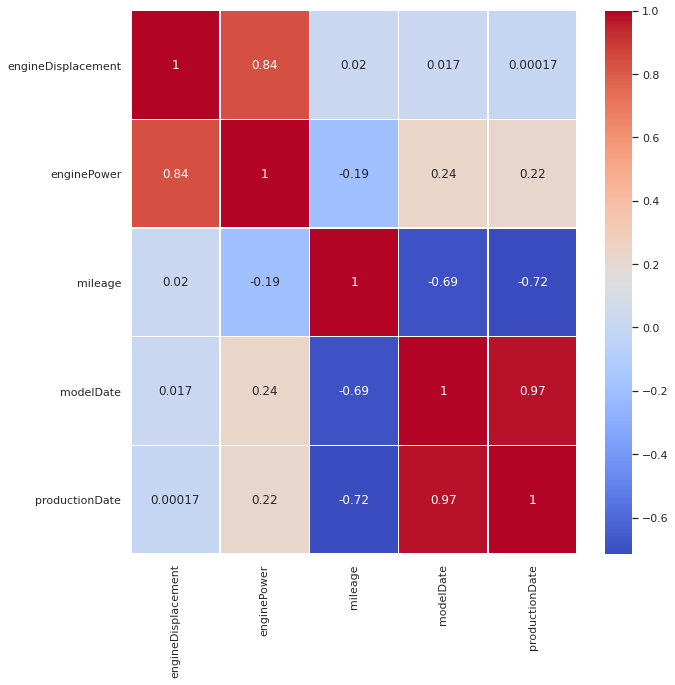

In [64]:
correlation = data[num_cols].corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)

Ясно, что год выхода на рынок модели очень сильно коррелирует с годом выпуска авто. Также очевидна обратная корреляция между пробегом и годом выпуска и прямая корреляция объема и мощности двигателя

In [65]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### Предобработка ############################################################## 
    # убираем ненужные для модели признаки
    df_output.drop(['car_url', 'name', 'Владение', 'Состояние', 'Таможня'], axis=1, inplace=True,)
    
    # переведем объем двигателя в мл
    df_output['engineDisplacement'] = df_output['engineDisplacement']*1000
    
    # ################### Feature Engineering ####################################################
    
    # Генерируем числовые признаки - статистики по пробегу в зависимости от модели, даты производства, марки, мощности и пр.
    df_output = mileage_features('model_name', 'productionDate', df_output)
    df_output = mileage_features('brand', 'productionDate', df_output)
    df_output = mileage_features('enginePower', 'productionDate', df_output)
    df_output = mileage_features('numberOfDoors', 'productionDate', df_output)
    df_output = mileage_features('Руль', 'productionDate', df_output)
    
    df_output.fillna(0, inplace=True)
    
    # логарифмирование
    #for col in num_cols:
    #    df_output[col] = df_output[col].apply(lambda w: np.log(w + 1))
    
    # нормирование
    #scaler = RobustScaler()
    #df_output[num_cols] = scaler.fit_transform(df_output[num_cols])
    
    ### Создаем dummy features из списка опций
    
    # Сформируем список уникальных опций
    all_equipment = set()
    for item in df_output.equipment_dict:
        for element in item:
            all_equipment.add(element)
    all_equipment = list(all_equipment)
    
    # Сгенерируем признаки
    for equipment in all_equipment:
        df_output[equipment] = df_output.equipment_dict.apply(lambda x: find_equip(x, equipment))
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать и признаки, из которых получены новые 
    df_output.drop(['description', 'equipment_dict'], axis=1, inplace=True,)
    
    return df_output

In [66]:
data_preproc = preproc_data(data)

In [67]:
data_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73822 entries, 0 to 73821
Columns: 249 entries, bodyType to alcantara
dtypes: float64(27), int64(212), object(10)
memory usage: 140.8+ MB


In [68]:
data_preproc.isna().sum()

bodyType                                          0
brand                                             0
color                                             0
engineDisplacement                                0
enginePower                                       0
fuelType                                          0
mileage                                           0
modelDate                                         0
model_name                                        0
numberOfDoors                                     0
productionDate                                    0
vehicleTransmission                               0
vendor                                            0
Владельцы                                         0
ПТС                                               0
Привод                                            0
Руль                                              0
sample                                            0
Price                                             0
min_mileage 

# ML

## 1. CatBoost

In [69]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [70]:
# Переводим признаки из float в int (иначе catboost выдает ошибку)
    
col_types = data_preproc.dtypes.reset_index()
col_types.columns=['Name', 'type']
float_to_convert = list(col_types[col_types['type']=='float64']['Name'])
  
for feature in float_to_convert:
    data_preproc[feature]=data_preproc[feature].astype('int32')

In [72]:
# отберем категориальные признаки, для передачи в модель
cat_cols_catboost = []
num_cols_catboost = ['enginePower', 'mileage']
    
for el in data_preproc.drop(['Price', 'sample'], axis=1).columns:
    if el not in num_cols_catboost:
        cat_cols_catboost.append(el)
len(cat_cols_catboost)
    

245

Разделим датасет обратно на трейн и тест

In [73]:
train_data = data_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = data_preproc.query('sample == 0').drop(['sample', 'Price'], axis=1)

y = train_data.Price.values
X = train_data.drop(['Price'], axis=1)

Разобъем трейн на обучающую и валидационную выборки

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

Подберем параметры для CatBoost

In [75]:
#model = CatBoostRegressor(iterations = 50,
#                          random_seed = RANDOM_SEED,
#                          cat_features=cat_cols_catboost,
#                          eval_metric='MAPE',
#                          custom_metric=['R2', 'MAE']
#                         )
#
#start = datetime.now()
#grid = {'learning_rate': [0.05, 0.1, 0.15],
#        'depth': [10, 12],
#        'l2_leaf_reg': [7, 9]}
#
#grid_search_result = model.grid_search(grid
#                                     ,X=X_train
#                                     ,y=np.log(y_train)
#                                     ,plot=True
#                                     ,verbose=False)
#
#print('\nНаилучшие параметры: ', grid_search_result['params'])

Обучим модель

In [76]:
#model = CatBoostRegressor(iterations=1000, #ITERATIONS,
#                          learning_rate=0.12,
#                          random_seed=RANDOM_SEED,
#                          #depth=8,
#                          #l2_leaf_reg=7,
#                          eval_metric='MAPE',
#                          custom_metric=['R2', 'MAE']
#                         )
#model.fit(X_train, y_train,
#         cat_features=cat_cols_catboost,
#         eval_set=(X_test, y_test),
#         verbose_eval=100,
#         use_best_model=True,
#         plot=True
#         )

In [78]:
#predict = model.predict(X_test)

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Лучшая полученная метрика - в районе 13,9%. На лидерборде - 20.87, но без учета поправки на удорожание. 

## Преобразуем датасет, чтобы его можно было скормить другим моделям.

In [79]:
col_types = data_preproc.dtypes.reset_index()
col_types.columns=['Name', 'type']
num_cols = list(col_types[col_types['type'] !='object']['Name'])
num_cols

['engineDisplacement',
 'enginePower',
 'mileage',
 'modelDate',
 'numberOfDoors',
 'productionDate',
 'Владельцы',
 'sample',
 'Price',
 'min_mileage by model_name productionDate',
 'max_mileage by model_name productionDate',
 'mean_mileage by model_name productionDate',
 'median_mileage by model_name productionDate',
 'std_mileage by model_name productionDate',
 'min_mileage by brand productionDate',
 'max_mileage by brand productionDate',
 'mean_mileage by brand productionDate',
 'median_mileage by brand productionDate',
 'std_mileage by brand productionDate',
 'min_mileage by enginePower productionDate',
 'max_mileage by enginePower productionDate',
 'mean_mileage by enginePower productionDate',
 'median_mileage by enginePower productionDate',
 'std_mileage by enginePower productionDate',
 'min_mileage by numberOfDoors productionDate',
 'max_mileage by numberOfDoors productionDate',
 'mean_mileage by numberOfDoors productionDate',
 'median_mileage by numberOfDoors productionDate',


In [80]:
num_cols=[
 'engineDisplacement',
 'enginePower',
 'mileage',
 'modelDate',
 'productionDate',
 'min_mileage by model_name productionDate',
 'max_mileage by model_name productionDate',
 'mean_mileage by model_name productionDate',
 'median_mileage by model_name productionDate',
 'std_mileage by model_name productionDate',
 'min_mileage by brand productionDate',
 'max_mileage by brand productionDate',
 'mean_mileage by brand productionDate',
 'median_mileage by brand productionDate',
 'std_mileage by brand productionDate',
 'min_mileage by enginePower productionDate',
 'max_mileage by enginePower productionDate',
 'mean_mileage by enginePower productionDate',
 'median_mileage by enginePower productionDate',
 'std_mileage by enginePower productionDate',
 'min_mileage by numberOfDoors productionDate',
 'max_mileage by numberOfDoors productionDate',
 'mean_mileage by numberOfDoors productionDate',
 'median_mileage by numberOfDoors productionDate',
 'std_mileage by numberOfDoors productionDate',
 'min_mileage by Руль productionDate',
 'max_mileage by Руль productionDate',
 'mean_mileage by Руль productionDate',
 'median_mileage by Руль productionDate',
 'std_mileage by Руль productionDate',
 ]

In [81]:
# логарифмирование
for col in num_cols:
    data_preproc[col] = data_preproc[col].apply(lambda w: np.log(w + 1))
    
# нормирование
scaler = RobustScaler()
data_preproc[num_cols] = scaler.fit_transform(data_preproc[num_cols])

#бинарные признаки

label_encoder = LabelEncoder()

for column in bin_cols:
    data_preproc[column] = label_encoder.fit_transform(data_preproc[column])

# one-hot-encoding
data_preproc = pd.get_dummies(data_preproc, columns=cat_cols)
data_preproc.shape

(73822, 928)

In [82]:
# Разделим датасет на трейн и тест обратно
train_data = data_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = data_preproc.query('sample == 0').drop(['sample', 'Price'], axis=1)

y = train_data.Price.values
X = train_data.drop(['Price'], axis=1)

In [83]:
# Разделим трейн на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## 2. RandomForest

In [ ]:
# Подберем параметры
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
#               'max_features': ['auto', 'sqrt'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}

#rfr = RandomForestRegressor(random_state=RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter=100, cv=3,
#                               verbose=10, random_state=RANDOM_SEED, n_jobs=-1)
#rf_random.fit(X_train, np.log(y_train))
#rf_random.best_params_

#rfr = rf_random.best_estimator_


In [84]:
# Обучим модель
#rfr = RandomForestRegressor(random_state=RANDOM_SEED,
#                            n_estimators=2000,
#                            min_samples_split=2,
#                            min_samples_leaf=1,
#                            max_features='sqrt',
#                            max_depth=None,
#                            bootstrap=False,
#                            n_jobs=-1,
#                            verbose=1)

#rfr.fit(X_train, np.log(y_train))



In [85]:
#predict_rfr = np.exp(rfr.predict(X_test))

#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность модели по метрике MAPE: 13.83%.

## 3. Gradient Boosting Regressor

In [86]:
# Подберем параметры
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
#               'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4]}

#gbr = GradientBoostingRegressor()
#gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions=random_grid, n_iter=100, cv=3,
#                                verbose=10, random_state=RANDOM_SEED, n_jobs=-1)
#gbr_random.fit(X_train, np.log(y_train))
#gbr_random.best_params_

In [ ]:
# Обучим модель
#gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                n_estimators=800,
#                                min_samples_split=5,
#                                min_samples_leaf=4,
#                                max_features='sqrt',
#                                max_depth=9
#                               )
#gbr.fit(X_train, np.log(y_train))

In [87]:
predict_gbr = np.exp(gbr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_gbr))*100:0.2f}%")

Точность модели по метрике MAPE: 12.67%. На лидерборде - 16.40

## 4. Бэггинг со случайным лесом - Не получилось. Перелимит по памяти на Kaggle

In [88]:
#rfr = RandomForestRegressor(random_state=RANDOM_SEED,
#                           n_estimators=300,
#                            min_samples_split=2,
#                            min_samples_leaf=1,
#                            max_features='sqrt',
#                            max_depth=None,
#                            bootstrap=False,
#                            n_jobs=-1,
#                            verbose=1)
#
#rfr.fit(X_train, np.log(y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   58.1s finished


RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=300,
                      n_jobs=-1, random_state=42, verbose=1)

In [90]:
#bag_model = BaggingRegressor(rfr, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
#bag_model.fit(X_train, y_train)

In [ ]:
#predict_bag = bag_model.predict(X_test)

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bag))*100:0.2f}%")

## 5. Бэггинг с градиентным бустингом

In [ ]:
#bag_model = BaggingRegressor(gbr, n_estimators=10, n_jobs=-1, random_state=RANDOM_SEED)
#bag_model.fit(X_train, y_train)

In [ ]:
#predict_bag = bag_model.predict(X_test)

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_bag))*100:0.2f}%")

Точность модели по метрике MAPE: 14.18%

## 6. Blending

In [93]:
#Предсказания разных моделей будем усреднять
#models = [GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                    n_estimators=800,
#                                    min_samples_split=5,
#                                    min_samples_leaf=4,
#                                    max_features='sqrt',
#                                    max_depth=9
#                                   ),
#          BaggingRegressor(
#              ExtraTreeRegressor(random_state=RANDOM_SEED),
#              n_estimators=500,
#              random_state=RANDOM_SEED,
#              n_jobs=-1,
#              verbose=2)]


def model_predict(models, X_train, y_train, X_val):
    pred_df = pd.DataFrame()
    for model_ in tqdm(models):
        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_val)
        pred_df[str(model_)[:6]] = y_pred               
    return pred_df


#pred_temp = model_predict(models, X_train, y_train, X_test)
#pred_temp['y_pred'] = pred_temp.mean(axis=1)

#predict = np.array(pred_temp['y_pred'])

# оцениваем точность
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.9s finished


Точность модели по метрике MAPE: 13.56%


Точность модели по метрике MAPE: 13.56%. Лучший результат на лидерборде - тут. 15.58, 46-е место.

Сделаем предсказание на всем трейне 

In [95]:
pred_temp = model_predict(models, X, np.log(y), test_data)
pred_temp['y_pred'] = pred_temp.mean(axis=1)

predict = np.array(pred_temp['y_pred'])

  0%|          | 0/2 [00:00<?, ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished


In [96]:
# Submission для блендинга

# Обратное преобразование 
predict_submission = np.exp(predict)

# Округлим предикт и скорректируем на 0.9 - поправочный коэффициент, учитывающий рост цен на автомобили.
predict_submission = (predict_submission // 1000) * 1000 * 0.9

## Stacking

In [103]:
#estimators=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                       n_estimators=800,
#                                       min_samples_split=5,
#                                       min_samples_leaf=4,
#                                       max_features='sqrt',
#                                       max_depth=9), n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)),
#             ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
#                                      colsample_bytree=0.5,
#                                      learning_rate=0.05,
#                                      #max_depth=12,
#                                      alpha=1,
#                                      n_estimators=500))
#           ]

#st_ensemble = StackingRegressor(estimators=estimators,
#                                final_estimator = CatBoostRegressor(iterations=1000,
#                                                                    learning_rate=0.12,
#                                                                    random_seed=RANDOM_SEED,
#                                                                    #depth=8,
#                                                                    #l2_leaf_reg=7,
#                                                                    eval_metric='MAPE',
#                                                                    custom_metric=['R2', 'MAE']
#                                                                   ),
#                                n_jobs=-1,
#                                verbose=5
#                               )

    
#st_ensemble.fit(X_train, np.log(y_train))

#predict_ensemble = np.exp(st_ensemble.predict(X_test))

#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble))*100:0.2f}%")

0:	learn: 0.0475648	total: 68.1ms	remaining: 1m 8s
1:	learn: 0.0422732	total: 76.4ms	remaining: 38.1s
2:	learn: 0.0376525	total: 83.8ms	remaining: 27.9s
3:	learn: 0.0337483	total: 90.8ms	remaining: 22.6s
4:	learn: 0.0301131	total: 98ms	remaining: 19.5s
5:	learn: 0.0269482	total: 105ms	remaining: 17.4s
6:	learn: 0.0242145	total: 112ms	remaining: 15.9s
7:	learn: 0.0218956	total: 118ms	remaining: 14.6s
8:	learn: 0.0198560	total: 125ms	remaining: 13.7s
9:	learn: 0.0181002	total: 132ms	remaining: 13.1s
10:	learn: 0.0166214	total: 139ms	remaining: 12.5s
11:	learn: 0.0154204	total: 144ms	remaining: 11.8s
12:	learn: 0.0143498	total: 150ms	remaining: 11.4s
13:	learn: 0.0134472	total: 156ms	remaining: 11s
14:	learn: 0.0127009	total: 162ms	remaining: 10.6s
15:	learn: 0.0120697	total: 168ms	remaining: 10.4s
16:	learn: 0.0115486	total: 176ms	remaining: 10.2s
17:	learn: 0.0111569	total: 183ms	remaining: 9.97s
18:	learn: 0.0108283	total: 189ms	remaining: 9.77s
19:	learn: 0.0105585	total: 195ms	remain

180:	learn: 0.0093023	total: 1.25s	remaining: 5.66s
181:	learn: 0.0093019	total: 1.26s	remaining: 5.65s
182:	learn: 0.0093015	total: 1.26s	remaining: 5.64s
183:	learn: 0.0093011	total: 1.27s	remaining: 5.63s
184:	learn: 0.0093009	total: 1.28s	remaining: 5.63s
185:	learn: 0.0092991	total: 1.28s	remaining: 5.62s
186:	learn: 0.0092981	total: 1.29s	remaining: 5.62s
187:	learn: 0.0092966	total: 1.3s	remaining: 5.61s
188:	learn: 0.0092947	total: 1.31s	remaining: 5.61s
189:	learn: 0.0092944	total: 1.31s	remaining: 5.6s
190:	learn: 0.0092931	total: 1.32s	remaining: 5.6s
191:	learn: 0.0092929	total: 1.33s	remaining: 5.59s
192:	learn: 0.0092912	total: 1.34s	remaining: 5.59s
193:	learn: 0.0092908	total: 1.34s	remaining: 5.58s
194:	learn: 0.0092905	total: 1.35s	remaining: 5.56s
195:	learn: 0.0092890	total: 1.35s	remaining: 5.55s
196:	learn: 0.0092877	total: 1.36s	remaining: 5.55s
197:	learn: 0.0092862	total: 1.37s	remaining: 5.54s
198:	learn: 0.0092860	total: 1.37s	remaining: 5.53s
199:	learn: 0.0

357:	learn: 0.0091850	total: 2.42s	remaining: 4.35s
358:	learn: 0.0091842	total: 2.43s	remaining: 4.34s
359:	learn: 0.0091839	total: 2.44s	remaining: 4.34s
360:	learn: 0.0091831	total: 2.45s	remaining: 4.33s
361:	learn: 0.0091830	total: 2.45s	remaining: 4.32s
362:	learn: 0.0091821	total: 2.46s	remaining: 4.31s
363:	learn: 0.0091818	total: 2.46s	remaining: 4.3s
364:	learn: 0.0091814	total: 2.47s	remaining: 4.29s
365:	learn: 0.0091806	total: 2.48s	remaining: 4.29s
366:	learn: 0.0091795	total: 2.48s	remaining: 4.28s
367:	learn: 0.0091790	total: 2.49s	remaining: 4.27s
368:	learn: 0.0091783	total: 2.49s	remaining: 4.26s
369:	learn: 0.0091779	total: 2.5s	remaining: 4.26s
370:	learn: 0.0091772	total: 2.51s	remaining: 4.25s
371:	learn: 0.0091771	total: 2.51s	remaining: 4.24s
372:	learn: 0.0091767	total: 2.52s	remaining: 4.24s
373:	learn: 0.0091759	total: 2.53s	remaining: 4.23s
374:	learn: 0.0091749	total: 2.53s	remaining: 4.22s
375:	learn: 0.0091740	total: 2.54s	remaining: 4.21s
376:	learn: 0.

516:	learn: 0.0091155	total: 3.6s	remaining: 3.36s
517:	learn: 0.0091152	total: 3.61s	remaining: 3.36s
518:	learn: 0.0091146	total: 3.62s	remaining: 3.35s
519:	learn: 0.0091142	total: 3.62s	remaining: 3.35s
520:	learn: 0.0091140	total: 3.63s	remaining: 3.34s
521:	learn: 0.0091136	total: 3.64s	remaining: 3.33s
522:	learn: 0.0091136	total: 3.65s	remaining: 3.32s
523:	learn: 0.0091135	total: 3.65s	remaining: 3.32s
524:	learn: 0.0091133	total: 3.66s	remaining: 3.31s
525:	learn: 0.0091129	total: 3.67s	remaining: 3.31s
526:	learn: 0.0091122	total: 3.68s	remaining: 3.3s
527:	learn: 0.0091116	total: 3.69s	remaining: 3.29s
528:	learn: 0.0091112	total: 3.69s	remaining: 3.29s
529:	learn: 0.0091106	total: 3.7s	remaining: 3.28s
530:	learn: 0.0091105	total: 3.71s	remaining: 3.28s
531:	learn: 0.0091102	total: 3.72s	remaining: 3.27s
532:	learn: 0.0091097	total: 3.73s	remaining: 3.27s
533:	learn: 0.0091096	total: 3.74s	remaining: 3.26s
534:	learn: 0.0091096	total: 3.74s	remaining: 3.25s
535:	learn: 0.0

683:	learn: 0.0090618	total: 4.79s	remaining: 2.21s
684:	learn: 0.0090617	total: 4.79s	remaining: 2.2s
685:	learn: 0.0090606	total: 4.8s	remaining: 2.2s
686:	learn: 0.0090604	total: 4.81s	remaining: 2.19s
687:	learn: 0.0090600	total: 4.82s	remaining: 2.18s
688:	learn: 0.0090594	total: 4.82s	remaining: 2.18s
689:	learn: 0.0090592	total: 4.83s	remaining: 2.17s
690:	learn: 0.0090590	total: 4.84s	remaining: 2.16s
691:	learn: 0.0090584	total: 4.84s	remaining: 2.15s
692:	learn: 0.0090582	total: 4.85s	remaining: 2.15s
693:	learn: 0.0090580	total: 4.85s	remaining: 2.14s
694:	learn: 0.0090575	total: 4.86s	remaining: 2.13s
695:	learn: 0.0090566	total: 4.86s	remaining: 2.12s
696:	learn: 0.0090563	total: 4.87s	remaining: 2.12s
697:	learn: 0.0090559	total: 4.88s	remaining: 2.11s
698:	learn: 0.0090556	total: 4.89s	remaining: 2.1s
699:	learn: 0.0090556	total: 4.89s	remaining: 2.1s
700:	learn: 0.0090552	total: 4.9s	remaining: 2.09s
701:	learn: 0.0090548	total: 4.91s	remaining: 2.08s
702:	learn: 0.0090

867:	learn: 0.0090066	total: 5.97s	remaining: 907ms
868:	learn: 0.0090061	total: 5.97s	remaining: 900ms
869:	learn: 0.0090061	total: 5.98s	remaining: 893ms
870:	learn: 0.0090059	total: 5.98s	remaining: 886ms
871:	learn: 0.0090056	total: 5.99s	remaining: 879ms
872:	learn: 0.0090055	total: 6s	remaining: 873ms
873:	learn: 0.0090048	total: 6s	remaining: 866ms
874:	learn: 0.0090045	total: 6.01s	remaining: 859ms
875:	learn: 0.0090043	total: 6.02s	remaining: 852ms
876:	learn: 0.0090040	total: 6.03s	remaining: 845ms
877:	learn: 0.0090038	total: 6.03s	remaining: 838ms
878:	learn: 0.0090037	total: 6.04s	remaining: 831ms
879:	learn: 0.0090034	total: 6.04s	remaining: 824ms
880:	learn: 0.0090031	total: 6.05s	remaining: 817ms
881:	learn: 0.0090027	total: 6.05s	remaining: 810ms
882:	learn: 0.0090023	total: 6.06s	remaining: 803ms
883:	learn: 0.0090020	total: 6.07s	remaining: 796ms
884:	learn: 0.0090015	total: 6.07s	remaining: 789ms
885:	learn: 0.0090009	total: 6.08s	remaining: 782ms
886:	learn: 0.0090

Точность модели по метрике MAPE: 12.63%

In [ ]:
# Обучим стекинговую модель на всем трейне
# st_ensemble.fit(X, np.log(y))

# Submission

In [97]:
# Предикт градиентного бустинга
#predict_submission = (np.exp(gbr.predict(test_data))// 1000) * 1000 * 0.9

# Предикт стекинга
# predict_submission = (np.exp(st_ensemble.predict(test_data)) // 1000) * 1000 * 0.9
predict_submission

array([ 662000., 1069000.,  932000., ...,  188000., 1180000., 1138000.])

In [98]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,662000.0
1,1100549428,1069000.0
2,1100658222,932000.0
3,1100937408,796000.0
4,1101037972,732000.0
5,1100912634,832000.0
6,1101228730,668000.0
7,1100165896,484000.0
8,1100768262,2034000.0
9,1101218501,757000.0
